In [1]:
# Variable params to variate with Papermill
string_test = "4paper_test01_15x2_9btsp_24ph_v20"
hours_before = 24 # How many hours of pollution data are we adding as input to the model (current - hours_before)
bootstrap = True
boostrap_factor = 15  # Number of times to repeat the bootstrap
boostrap_threshold = 2.9


In [2]:
# Fixed params not varied with Papermill

In [3]:
import os
import pickle
import sys
import time
from datetime import date, datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from pandas import DataFrame
from sklearn import preprocessing

from ai_common.constants.AI_params import NormParams, TrainingParams, ModelParams
import ai_common.training.trainingutils as utilsNN
from ai_common.models.modelSelector import select_1d_model
from conf.MakeWRF_and_DB_CSV_UserConfiguration import getPreprocWRFParams
from conf.TrainingUserConfiguration import getTrainingParams
from conf.localConstants import constants
from conf.params import LocalTrainingParams, PreprocParams
from os.path import join
from proj_io.inout import create_folder, add_forecasted_hours, add_previous_hours, filter_data, get_column_names, read_merged_files, save_columns
from proj_preproc.preproc import apply_bootstrap, normalizeData
from viz.figure_generator import plot_input_output_data


# Filtering warnings:
import warnings

warnings.filterwarnings("ignore", message="DataFrame is highly fragmented")
warnings.simplefilter(action='ignore', category=pd.core.common.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', 'SettingWithCopyWarning')
warnings.filterwarnings('ignore', category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages, 1 = filter out INFO, 2 = filter out WARNING and INFO, 3 = filter out ERROR, WARNING, and INFO


In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

In [5]:
config = getTrainingParams()
stations = config[LocalTrainingParams.stations]
pollutants = config[LocalTrainingParams.pollutants]
start_year = 2010
end_year = 2019
cur_pollutant = 'otres'
cur_station = 'MER'

input_folder = config[TrainingParams.input_folder]
output_folder = config[TrainingParams.output_folder]
output_folder = join(output_folder,F"{string_test}_{start_year}_{end_year}")
val_perc = config[TrainingParams.validation_percentage]
test_perc = config[TrainingParams.test_percentage]
eval_metrics = config[TrainingParams.evaluation_metrics]
loss_func = config[TrainingParams.loss_function]
batch_size = config[TrainingParams.batch_size]
epochs = config[TrainingParams.epochs]
model_name_user = config[TrainingParams.config_name]
optimizer = config[TrainingParams.optimizer]
forecasted_hours = config[LocalTrainingParams.forecasted_hours]
norm_type = config[TrainingParams.normalization_type]

split_info_folder = join(output_folder, 'Splits')
parameters_folder = join(output_folder, 'Parameters')
weights_folder = join(output_folder, 'models')
logs_folder = join(output_folder, 'logs')
imgs_folder= join(output_folder, 'imgs')
norm_folder = join(output_folder, 'norm')

create_folder(split_info_folder)
create_folder(parameters_folder)
create_folder(weights_folder)
create_folder(logs_folder)
create_folder(norm_folder)
create_folder(imgs_folder)

In [6]:
input_folder = config[TrainingParams.input_folder]
data = read_merged_files(input_folder, start_year, end_year)
config[ModelParams.INPUT_SIZE] = len(data.columns)

datetimes_str = data.index.values
datetimes = np.array([datetime.strptime(x, constants.datetime_format.value) for x in datetimes_str])

Reading years 2010 to 2019...
============ Reading data for: 2010: /ZION/AirPollutionData/Data/MergedDataCSV/16/2010_AllStations.csv
============ Reading data for: 2011: /ZION/AirPollutionData/Data/MergedDataCSV/16/2011_AllStations.csv
============ Reading data for: 2012: /ZION/AirPollutionData/Data/MergedDataCSV/16/2012_AllStations.csv
============ Reading data for: 2013: /ZION/AirPollutionData/Data/MergedDataCSV/16/2013_AllStations.csv
============ Reading data for: 2014: /ZION/AirPollutionData/Data/MergedDataCSV/16/2014_AllStations.csv
============ Reading data for: 2015: /ZION/AirPollutionData/Data/MergedDataCSV/16/2015_AllStations.csv
============ Reading data for: 2016: /ZION/AirPollutionData/Data/MergedDataCSV/16/2016_AllStations.csv
============ Reading data for: 2017: /ZION/AirPollutionData/Data/MergedDataCSV/16/2017_AllStations.csv
============ Reading data for: 2018: /ZION/AirPollutionData/Data/MergedDataCSV/16/2018_AllStations.csv
============ Reading data for: 2019: /ZION/

In [7]:
now = datetime.utcnow().strftime("%Y_%m_%d_%H_%M")
model_name = F'{model_name_user}_{cur_pollutant}_{now}'
file_name_norm = join(norm_folder,F"{model_name}_scaler.pkl")  
print("Normalizing data....")
data_norm_df = normalizeData(data, norm_type, file_name_norm)

Normalizing data....
Scaler/normalizer object saved to: /ZION/AirPollutionData/Data/TrainingTestsOZ/4paper_test01_15x2_9btsp_24ph_v20_2010_2019/norm/TestOZ_otres_2024_01_20_02_03_scaler.pkl
Done! Current shape: (87658, 2925) 


In [8]:
all_contaminant_columns, all_meteo_columns, all_time_colums = get_column_names(data_norm_df)

In [9]:
# Here we remove all the data of other pollutants
X_df = filter_data(data_norm_df, filter_type='single_pollutant',
                   filtered_pollutant=cur_pollutant) 

print(X_df.columns.values)
print(F'X {X_df.shape}, Memory usage: {X_df.memory_usage().sum()/1024**2:02f} MB')

Keeping columns: 2730 original columns: 2925
['cont_otres_UIZ' 'cont_otres_AJU' 'cont_otres_ATI' ... 'GLW_13_h23'
 'GLW_14_h23' 'GLW_15_h23']
X (87658, 2730), Memory usage: 1826.431259 MB


In [10]:
print(F"Building X and Y ....")
X_df = add_previous_hours(X_df, hours_before=hours_before)

Building X and Y ....
	Adding the previous hours of the pollutants as additional columns...
X (87658, 3450), Memory usage: 2307.951035 MB
Done!


In [11]:
print("\tAdding the forecasted hours of the pollutant as the predicted column Y...")
Y_df = add_forecasted_hours(X_df, cur_pollutant, range(1,forecasted_hours+1))

	Adding the forecasted hours of the pollutant as the predicted column Y...
Shape of Y: (87658, 720)
Done!


In [12]:
X_df = X_df.iloc[hours_before:,:]
Y_df = Y_df.iloc[hours_before:,:]
save_columns(Y_df, join(output_folder, 'Y_columns.csv'))
save_columns(X_df, join(output_folder, 'X_columns.csv'))
print("Done!")

print(F'Original {data_norm_df.shape}')
print(F'X {X_df.shape}, Memory usage: {X_df.memory_usage().sum()/1024**2:02f} MB')
print(F'Y {Y_df.shape}, Memory usage: {Y_df.memory_usage().sum()/1024**2:02f} MB')

Done saving file: /ZION/AirPollutionData/Data/TrainingTestsOZ/4paper_test01_15x2_9btsp_24ph_v20_2010_2019/Y_columns.csv
Done saving file: /ZION/AirPollutionData/Data/TrainingTestsOZ/4paper_test01_15x2_9btsp_24ph_v20_2010_2019/X_columns.csv
Done!
Original (87658, 2925)
X (87634, 3450), Memory usage: 2307.319138 MB
Y (87634, 720), Memory usage: 482.056534 MB


In [13]:
print("Splitting training and validation data by year....")

splits_file = join(split_info_folder, F'splits_{model_name}.csv')
train_idxs, val_idxs, test_idxs = utilsNN.split_train_validation_and_test(
    len(X_df), val_perc, test_perc, shuffle_ids=False, file_name=splits_file)

Splitting training and validation data by year....
Saving split information...


In [14]:
# Here we remove the datetime indexes so we need to consider that 
print("Removing time index...")
X_df.reset_index(drop=True, inplace=True)
Y_df.reset_index(drop=True, inplace=True)

X_df_train = X_df.iloc[train_idxs]
Y_df_train = Y_df.iloc[train_idxs]

X_df_val = X_df.iloc[val_idxs]
Y_df_val = Y_df.iloc[val_idxs]

print(F'X train {X_df_train.shape}, Memory usage: {X_df_train.memory_usage().sum()/1024**2:02f} MB')
print(F'Y train {Y_df_train.shape}, Memory usage: {Y_df_train.memory_usage().sum()/1024**2:02f} MB')
print(F'X val {X_df_val.shape}, Memory usage: {X_df_val.memory_usage().sum()/1024**2:02f} MB')
print(F'Y val {Y_df_val.shape}, Memory usage: {Y_df_val.memory_usage().sum()/1024**2:02f} MB')

print("Done!")

Removing time index...
X train (78870, 3450), Memory usage: 2076.571426 MB
Y train (78870, 720), Memory usage: 433.847580 MB
X val (8764, 3450), Memory usage: 230.747711 MB
Y val (8764, 720), Memory usage: 48.208954 MB
Done!


In [15]:
if bootstrap:
    # -------- Bootstrapping the data
    # Se utiliza esta estacion para decidir que indices son los que se van a usar para el bootstrapping.
    # Only the indexes for this station that are above the threshold will be used for bootstrapping
    station = "MER" 
    print("Bootstrapping the data...")
    print(F'X train {X_df_train.shape}, Memory usage: {X_df_train.memory_usage().sum()/1024**2:02f} MB')
    print(F'Y train {Y_df_train.shape}, Memory usage: {Y_df_train.memory_usage().sum()/1024**2:02f} MB')
    X_df_train, Y_df_train = apply_bootstrap(X_df_train, Y_df_train, cur_pollutant, station, boostrap_threshold, forecasted_hours, boostrap_factor)
    print(F'X train bootstrapped {X_df_train.shape}, Memory usage: {X_df_train.memory_usage().sum()/1024**2:02f} MB')
    print(F'Y train bootstrapped {Y_df_train.shape}, Memory usage: {Y_df_train.memory_usage().sum()/1024**2:02f} MB')
    print(F'X val {X_df_val.shape}, Memory usage: {X_df_val.memory_usage().sum()/1024**2:02f} MB')
    print(F'Y val {Y_df_val.shape}, Memory usage: {Y_df_val.memory_usage().sum()/1024**2:02f} MB')

Bootstrapping the data...
X train (78870, 3450), Memory usage: 2076.571426 MB
Y train (78870, 720), Memory usage: 433.847580 MB
Bootstrapping the data...
X train bootstrapped (238455, 3450), Memory usage: 6278.291359 MB
Y train bootstrapped (238455, 720), Memory usage: 1311.691704 MB
X val (8764, 3450), Memory usage: 230.747711 MB
Y val (8764, 720), Memory usage: 48.208954 MB


In [16]:
replace_value = 0
print(f"Replacing nan values with {replace_value}...")
X_df_train.fillna(replace_value, inplace=True)
X_df_val.fillna(replace_value, inplace=True)
Y_df_train.fillna(replace_value, inplace=True)
Y_df_val.fillna(replace_value, inplace=True)

Replacing nan values with 0...


In [17]:
#print("Visualizing input and outputs...")
#plot_input_output_data(X_df_train, Y_df_train, cur_station, cur_pollutant, 
#                       imgs_folder, model_name)

In [18]:
print(f"Train examples: {X_df_train.shape[0]}")
print(f"Validation examples {X_df_val.shape[0]}")

# ******************* Selecting the model **********************
config[ModelParams.INPUT_SIZE] = X_df_train.shape[1]
config[ModelParams.NUMBER_OF_OUTPUT_CLASSES] = Y_df_train.shape[1]

model = select_1d_model(config)
print("Done!")


#print("Getting callbacks ...")
all_callbacks = utilsNN.get_all_callbacks(model_name=model_name,
                                           early_stopping_func=F'val_{eval_metrics[0].__name__}',
                                             weights_folder=weights_folder,
                                             patience=50,
                                             logs_folder=logs_folder)

print("Compiling model ...")
model.compile(loss=loss_func, optimizer=optimizer, metrics=eval_metrics)
model.summary()

Train examples: 238455
Validation examples 8764
Done!
The early stopping callback is in auto mode
Compiling model ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3450)]            0         
                                                                 
 input_layer (Dense)         (None, 300)               1035300   
                                                                 
 hidden_1 (Dense)            (None, 300)               90300     
                                                                 
 batch_normalization (BatchN  (None, 300)              1200      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 hidden_2

In [19]:

print("Training ...")
model.fit(X_df_train.values, Y_df_train.values,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_df_val.values, Y_df_val.values),
                    shuffle=True,
                    callbacks=all_callbacks)

Training ...
Epoch 1/5000
48/48 [==============================] - 4s 65ms/step - loss: 1.3284 - mean_squared_error: 1.3284 - val_loss: 0.6156 - val_mean_squared_error: 0.6156 - lr: 1.0000e-04
Epoch 2/5000
48/48 [==============================] - 2s 46ms/step - loss: 0.8138 - mean_squared_error: 0.8138 - val_loss: 0.5800 - val_mean_squared_error: 0.5800 - lr: 1.0000e-04
Epoch 3/5000
48/48 [==============================] - 2s 48ms/step - loss: 0.6627 - mean_squared_error: 0.6627 - val_loss: 0.5196 - val_mean_squared_error: 0.5196 - lr: 1.0000e-04
Epoch 4/5000
48/48 [==============================] - 2s 46ms/step - loss: 0.6007 - mean_squared_error: 0.6007 - val_loss: 0.4294 - val_mean_squared_error: 0.4294 - lr: 1.0000e-04
Epoch 5/5000
48/48 [==============================] - 2s 43ms/step - loss: 0.5604 - mean_squared_error: 0.5604 - val_loss: 0.3606 - val_mean_squared_error: 0.3606 - lr: 1.0000e-04
Epoch 6/5000
48/48 [==============================] - 2s 43ms/step - loss: 0.5268 - mea

48/48 [==============================] - 3s 53ms/step - loss: 0.2326 - mean_squared_error: 0.2326 - val_loss: 0.2565 - val_mean_squared_error: 0.2565 - lr: 2.0190e-05
Epoch 47/5000
48/48 [==============================] - 3s 55ms/step - loss: 0.2320 - mean_squared_error: 0.2320 - val_loss: 0.2573 - val_mean_squared_error: 0.2573 - lr: 1.8268e-05
Epoch 48/5000
48/48 [==============================] - 3s 55ms/step - loss: 0.2314 - mean_squared_error: 0.2314 - val_loss: 0.2567 - val_mean_squared_error: 0.2567 - lr: 1.6530e-05
Epoch 49/5000
48/48 [==============================] - 3s 55ms/step - loss: 0.2309 - mean_squared_error: 0.2309 - val_loss: 0.2576 - val_mean_squared_error: 0.2576 - lr: 1.4957e-05
Epoch 50/5000
48/48 [==============================] - 3s 59ms/step - loss: 0.2304 - mean_squared_error: 0.2304 - val_loss: 0.2579 - val_mean_squared_error: 0.2579 - lr: 1.3534e-05
Epoch 51/5000
48/48 [==============================] - 3s 65ms/step - loss: 0.2301 - mean_squared_error: 0.23

48/48 [==============================] - 2s 51ms/step - loss: 0.2259 - mean_squared_error: 0.2259 - val_loss: 0.2575 - val_mean_squared_error: 0.2575 - lr: 2.2429e-07
Epoch 92/5000
48/48 [==============================] - 3s 58ms/step - loss: 0.2260 - mean_squared_error: 0.2260 - val_loss: 0.2575 - val_mean_squared_error: 0.2575 - lr: 2.0294e-07
Epoch 93/5000
48/48 [==============================] - 3s 55ms/step - loss: 0.2261 - mean_squared_error: 0.2261 - val_loss: 0.2575 - val_mean_squared_error: 0.2575 - lr: 1.8363e-07
Epoch 94/5000
48/48 [==============================] - 2s 52ms/step - loss: 0.2259 - mean_squared_error: 0.2259 - val_loss: 0.2575 - val_mean_squared_error: 0.2575 - lr: 1.6616e-07


# Evaluation after training

In [20]:
from copy import copy
training_results_folder = f'{output_folder}' # copied this way on train-evaluation run,  otherwise on only evaluation something like...'/ZION/AirPollutionData/Data/TrainingTestsPS/test01_15x3_5btsp_24ph_2010_2019' #
INPUT_SIZE = copy(config[ModelParams.INPUT_SIZE])


In [21]:
print(training_results_folder,INPUT_SIZE, sep="\n")


/ZION/AirPollutionData/Data/TrainingTestsOZ/4paper_test01_15x2_9btsp_24ph_v20_2010_2019
3450


In [22]:
#%%
import glob
import os
import sys
import time
from copy import deepcopy
from datetime import date, datetime, timedelta
from os import listdir
from os.path import join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
from pandas import DataFrame
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

from ai_common.constants.AI_params import *
from ai_common.models.modelSelector import select_1d_model
from AI.data_generation.utilsDataFormat import *
from conf.TrainingUserConfiguration import get_makeprediction_config
from conf.localConstants import constants
from conf.params import LocalTrainingParams
from proj_io.inout import create_folder, filter_data, add_previous_hours, add_forecasted_hours, get_column_names
from proj_preproc.preproc import loadScaler, extract_model_name
from proj_prediction.prediction import analyze_column, scatter_plot_by_column, compile_scaler, average_metric, average_metric_by_hour, analyze_multi_hour_plot, plot_max_difference, plot_forecast_hours, plot_max_and_mean_difference, calculate_imeca
from viz.figure_generator import plot_input_output_data

# import seaborn as sns
# import matplotlib
# matplotlib.use('Agg')  # Set up Matplotlib to use backend 'Agg' supress plot windows in batchmodes


In [23]:
# In case we want to save the columns to temporal files for debugging purposes
os.environ["CUDA_VISIBLE_DEVICES"] = "" # No  CUDA on evaluation, not needed in general

config = get_makeprediction_config()
# *********** Reads the parameters ***********

input_file = config[ClassificationParams.input_file]
output_folder = config[ClassificationParams.output_folder]
output_imgs_folder = config[ClassificationParams.output_imgs_folder]
output_file_name = config[ClassificationParams.output_file_name]
model_weights_file = config[ClassificationParams.model_weights_file]
forecasted_hours = config[LocalTrainingParams.forecasted_hours]
pollutant = config[LocalTrainingParams.pollutants][0]

# ********** Reading and preprocessing data *******
all_stations = [
    "UIZ", "AJU", "ATI", "CUA", "SFE", "SAG", "CUT", "PED", "TAH", "GAM",
    "IZT", "CCA", "HGM", "LPR", "MGH", "CAM", "FAC", "TLA", "MER", "XAL",
    "LLA", "TLI", "UAX", "BJU", "MPA", "MON", "NEZ", "INN", "AJM", "VIF"
]

evaluate_stations = ["UIZ", "AJU", "ATI", "UAX"]
evaluate_hours = [1, 6, 12, 18, 24]

# Iterate over the stations
models_folder = '/ZION/AirPollutionData/Data/Training/cont_otres_UIZ/models/'
data_folder = '/ZION/AirPollutionData/Data/MergedDataCSV/16/'

test_year = 2019

# %%
# cur_station is now a fixed value
cur_station = 'MER' # just to infer some statistics 


# %% Extract model name from weights file_names.hdf5
models_path = join(training_results_folder, 'models')
model_name = extract_model_name(models_path)
print(model_name)

# file with testing data
hardcoded_input_file = '/ZION/AirPollutionData/Data/MergedDataCSV/16/2019_AllStations.csv'

# path to normalization data
norm_folder = join(training_results_folder,'norm')

imgs_folder = training_results_folder

path_csvs = training_results_folder

#hours_before = 0 # now it is readed from training...

print(f"""training_results_folder:{training_results_folder}
model_name:{model_name}
hardcoded_input_file:{hardcoded_input_file}
norm_folder:{norm_folder}
imgs_folder:{imgs_folder}
path_csvs:{path_csvs}
""")


print(f"""input_file:{input_file}
output_folder:{output_folder}
output_imgs_folder:{output_imgs_folder}
output_file_name:{output_file_name}
model_weights_file:{model_weights_file}
forecasted_hours:{forecasted_hours}
pollutant:{pollutant}
""")


TestOZ_otres_2024_01_19_22_05
training_results_folder:/ZION/AirPollutionData/Data/TrainingTestsOZ/4paper_test01_15x2_9btsp_24ph_v20_2010_2019
model_name:TestOZ_otres_2024_01_19_22_05
hardcoded_input_file:/ZION/AirPollutionData/Data/MergedDataCSV/16/2019_AllStations.csv
norm_folder:/ZION/AirPollutionData/Data/TrainingTestsOZ/4paper_test01_15x2_9btsp_24ph_v20_2010_2019/norm
imgs_folder:/ZION/AirPollutionData/Data/TrainingTestsOZ/4paper_test01_15x2_9btsp_24ph_v20_2010_2019
path_csvs:/ZION/AirPollutionData/Data/TrainingTestsOZ/4paper_test01_15x2_9btsp_24ph_v20_2010_2019

input_file:/ZION/AirPollutionData/Data/MergedDataCSV/16/2015_cont_otres_AllStations.csv
output_folder:/ZION/AirPollutionData/Data/Results
output_imgs_folder:/ZION/AirPollutionData/Data/Results/TestOZ
output_file_name:/ZION/AirPollutionData/TrainingTESTOZ/Results/TestOZ.csv
model_weights_file:/ZION/AirPollutionData/TrainingTESTOZ/models
forecasted_hours:24
pollutant:otres



In [24]:
# %% Definir o cargar los folder donde se exportaran imágenes y datos

output_results_folder = join(output_imgs_folder, model_name)
output_results_folder_img = join(output_results_folder, 'imgs')
output_results_folder_data = join(output_results_folder, 'data')

create_folder(output_results_folder)
create_folder(output_results_folder_img)
create_folder(output_results_folder_data)


In [25]:

model_name_user = config[TrainingParams.config_name]
print(f'model_name_user: {model_name_user}')
print(f'output_folder: {output_folder}')


model_name_user: TestOZ
output_folder: /ZION/AirPollutionData/Data/Results


In [26]:
#%% Loading the best weight file on the weights folder

path_model_weights = join(f'{training_results_folder}',f'models')
print(f'\nModel weight file to use: \n\n {path_model_weights}\n\n')

model_weights_file = join(path_model_weights,f'{model_name}*')
weight_files = glob.glob(model_weights_file)
lista_weights =[]
for item in weight_files:
    lista_weights.append(float(item.split('/')[-1].split('-')[-1].split('.hdf5')[0]))
print(f'Weighs on dir:{lista_weights}')
model_weights_file = glob.glob(join(path_model_weights,f'{model_name}*{min(lista_weights)}*'))
model_weights_file = model_weights_file[0]
print(f'\nModel weight file to use of    {min(lista_weights)}: \n\n',model_weights_file)



Model weight file to use: 

 /ZION/AirPollutionData/Data/TrainingTestsOZ/4paper_test01_15x2_9btsp_24ph_v20_2010_2019/models


Weighs on dir:[0.6170435, 0.58144557, 0.52940625, 0.42668545, 0.35524201, 0.32327899, 0.31246829, 0.30658108, 0.30194521, 0.29588869, 0.29147896, 0.28725898, 0.28371775, 0.27962747, 0.27742404, 0.27627948, 0.27417359, 0.27345878, 0.27071443, 0.26812977, 0.26760328, 0.26562431, 0.2634874, 0.26280171, 0.26138049, 0.25954714, 0.2574884, 0.25681114]

Model weight file to use of    0.25681114: 

 /ZION/AirPollutionData/Data/TrainingTestsOZ/4paper_test01_15x2_9btsp_24ph_v20_2010_2019/models/TestOZ_otres_2024_01_19_22_05-epoch-40-loss-0.25681114.hdf5


In [27]:
# Selects the proper model file for the current station
assert len(model_weights_file) > 0
assert len(input_file) > 0

print(F"input file:\n\n {input_file}\n")

input file:

 /ZION/AirPollutionData/Data/MergedDataCSV/16/2015_cont_otres_AllStations.csv



In [28]:
#%% data test file
input_file = hardcoded_input_file
data = pd.read_csv(input_file, index_col=0)

In [29]:
#%% Redo the test dataset data as in the hotvectors used during training.
datetimes_str = data.index.values
datetimes = np.array([
    datetime.strptime(x, constants.datetime_format.value)
    for x in datetimes_str
])


In [30]:
# %% -------- Normalizing data
# loading original scaler object
file_name_norm = join(norm_folder,F"{model_name}_scaler.pkl")  
scaler = loadScaler(file_name_norm)

# %% generating an scaler according to data
new_scaler_cols = data.columns.tolist()
old_features = scaler.feature_names_in_.tolist()
#print(old_features)

# %%
# desired prefix
prefijo = 'plusfake_x_'
new_scaler_cols = [prefijo + elemento for elemento in new_scaler_cols]
new_scaler = compile_scaler(scaler,new_scaler_cols)

In [31]:
#%%
print("Normalizing data....")
data_norm_np = new_scaler.transform(data)
data_norm_df = DataFrame(data_norm_np, columns=data.columns, index=data.index)

print(data_norm_df)

Normalizing data....
                     cont_otres_UIZ  cont_otres_AJU  cont_otres_ATI  \
fecha                                                                 
2019-01-01 00:00:00             NaN             NaN             NaN   
2019-01-01 01:00:00             NaN             NaN             NaN   
2019-01-01 02:00:00             NaN             NaN             NaN   
2019-01-01 03:00:00       -0.868778       -0.760552       -0.986345   
2019-01-01 04:00:00       -0.868778       -0.760552       -0.986345   
...                             ...             ...             ...   
2019-12-31 20:00:00       -0.543884       -0.531581       -1.069433   
2019-12-31 21:00:00       -0.688281       -1.065846       -0.861714   
2019-12-31 22:00:00       -0.652182       -1.065846       -0.944801   
2019-12-31 23:00:00             NaN             NaN             NaN   
2020-01-01 00:00:00       -0.760480             NaN       -1.027889   

                     cont_otres_CUA  cont_otres_SFE  co

In [32]:
#%% Making of the hotvector

# %% ====== Getting all the orignal columns by type
all_contaminant_columns, all_meteo_columns, all_time_colums = get_column_names(data_norm_df)


# %% ====== Remove columns for other pollutants
cur_pollutant = 'otres'
X_df = filter_data(data_norm_df, filter_type='single_pollutant',
                   filtered_pollutant=cur_pollutant) 

print(X_df.columns.values)
print(F'X {X_df.shape}, Memory usage: {X_df.memory_usage().sum()/1024**2:02f} MB')

# %% ====== Adding the previous hours of the pollutants as extra columns (all contaminants)
print(F"Building X and Y ....")
X_df = add_previous_hours(X_df, hours_before)

# %% ====== Adding the forecasted hours of the pollutants as the predicted column Y (specific contaminant)
print("\tAdding the forecasted hours of the pollutant as the predicted column Y...")
Y_df = add_forecasted_hours(X_df, cur_pollutant, range(1,forecasted_hours+1))

# %% Remove the first hours because Print the final shape of X and Y
X_df = X_df.iloc[hours_before:,:]
Y_df = Y_df.iloc[hours_before:,:]
print("Done!")

print(F'Original {data_norm_df.shape}')
print(F'X {X_df.shape}, Memory usage: {X_df.memory_usage().sum()/1024**2:02f} MB')
print(F'Y {Y_df.shape}, Memory usage: {Y_df.memory_usage().sum()/1024**2:02f} MB')

# %%
print("Removing time index...")
X_df.reset_index(drop=True, inplace=True)
Y_df.reset_index(drop=True, inplace=True)

#%% Replace all the nan values with another value
replace_value = 0
print(f"Replacing nan values with {replace_value}...")
X_df.fillna(replace_value, inplace=True)

# comment to preserv nan in Y_df 
# Y_df.fillna(replace_value, inplace=True)


Keeping columns: 2730 original columns: 2925
['cont_otres_UIZ' 'cont_otres_AJU' 'cont_otres_ATI' ... 'GLW_13_h23'
 'GLW_14_h23' 'GLW_15_h23']
X (8761, 2730), Memory usage: 182.543114 MB
Building X and Y ....
	Adding the previous hours of the pollutants as additional columns...
X (8761, 3450), Memory usage: 230.668724 MB
Done!
	Adding the forecasted hours of the pollutant as the predicted column Y...
Shape of Y: (8761, 720)
Done!
Done!
Original (8761, 2925)
X (8737, 3450), Memory usage: 230.036827 MB
Y (8737, 720), Memory usage: 48.060432 MB
Removing time index...
Replacing nan values with 0...


In [33]:
# %% Visualize input and outputs
#print("Visualizing input and outputs...")

#plot_input_output_data(X_df, Y_df, cur_station, cur_pollutant, 
#                       output_results_folder_img, model_name) # previously used imgs_folder


Reading model ....
Reading weights ....
   plus_01_cont_otres_UIZ  plus_01_cont_otres_AJU  plus_01_cont_otres_ATI  \
0               10.236012               23.426582               15.598575   
1                9.563513               21.777802               14.017680   
2                9.606092               21.676371               12.433171   
3               11.045826               19.124401               10.403578   
4                9.123529               17.616529                7.909872   

   plus_01_cont_otres_CUA  plus_01_cont_otres_SFE  plus_01_cont_otres_SAG  \
0               21.603868               21.723078               12.625141   
1               20.309635               19.959576               10.788396   
2               18.667459               18.686617                9.579809   
3               16.336737               17.481993                8.992292   
4               13.656332               14.587790                7.720312   

   plus_01_cont_otres_CUT  plus_01

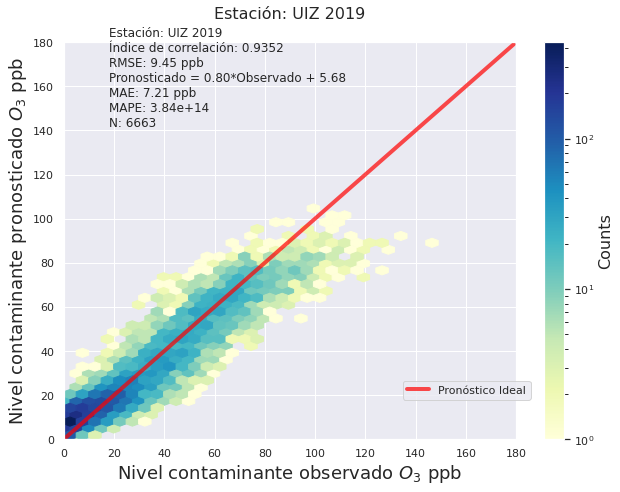

column name:plus_06_cont_otres_UIZ
Índice de correlación:                     0.8965


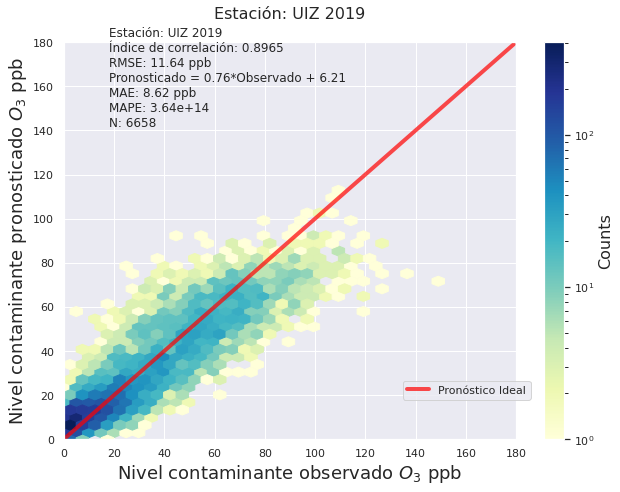

column name:plus_12_cont_otres_UIZ
Índice de correlación:                     0.8951


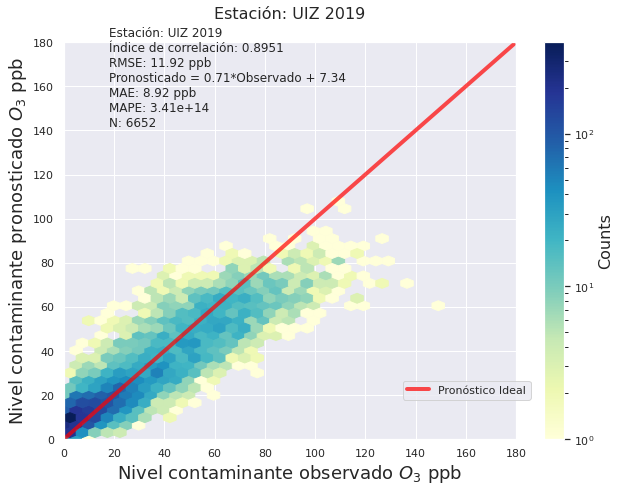

column name:plus_18_cont_otres_UIZ
Índice de correlación:                     0.8861


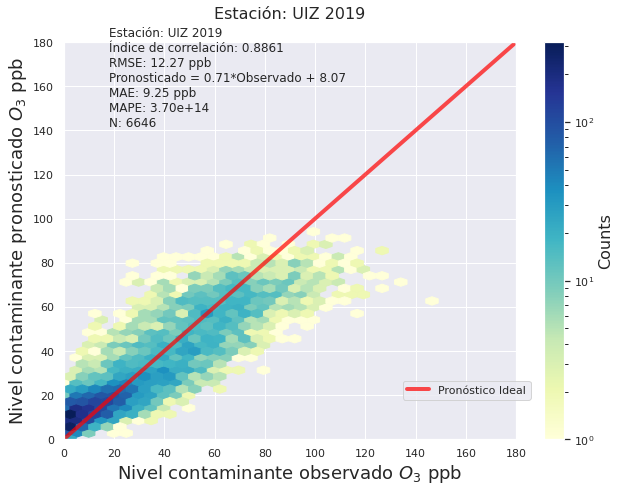

column name:plus_24_cont_otres_UIZ
Índice de correlación:                     0.8826


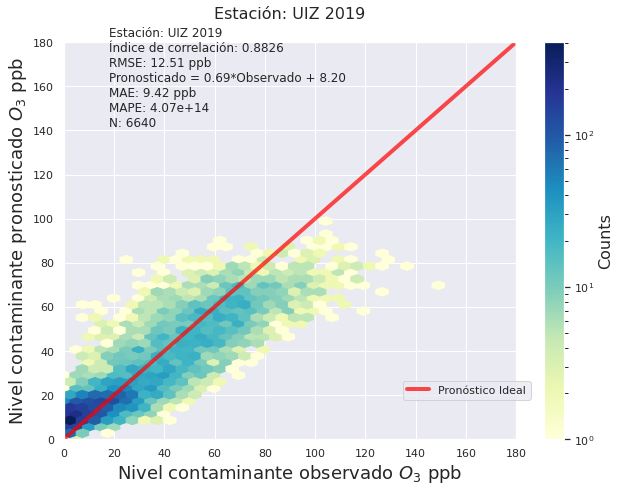

column name:plus_01_cont_otres_AJU
Índice de correlación:                     0.9026


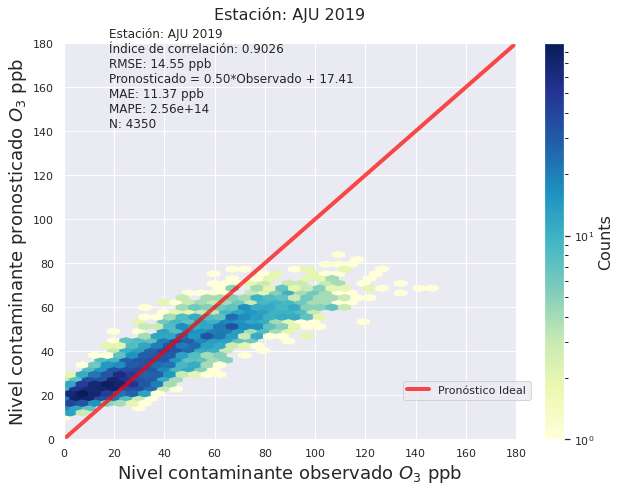

column name:plus_06_cont_otres_AJU
Índice de correlación:                     0.8626


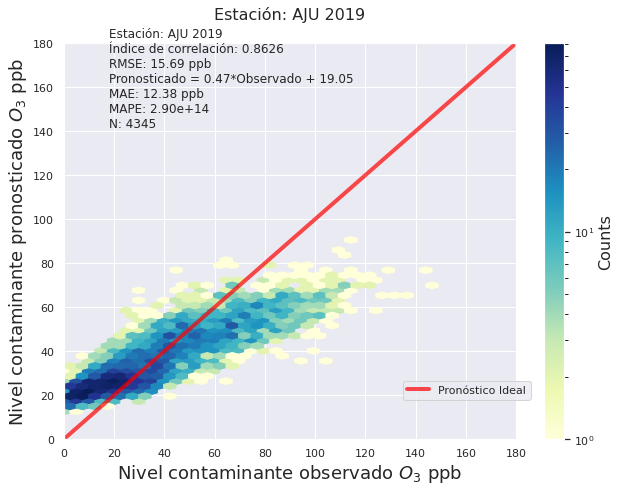

column name:plus_12_cont_otres_AJU
Índice de correlación:                     0.8661


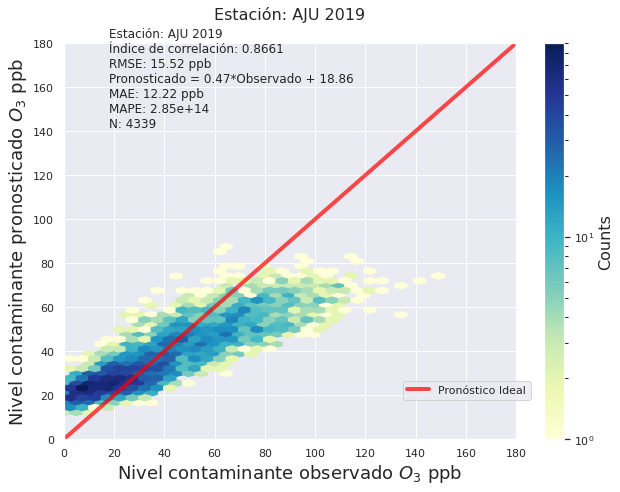

column name:plus_18_cont_otres_AJU
Índice de correlación:                     0.8581


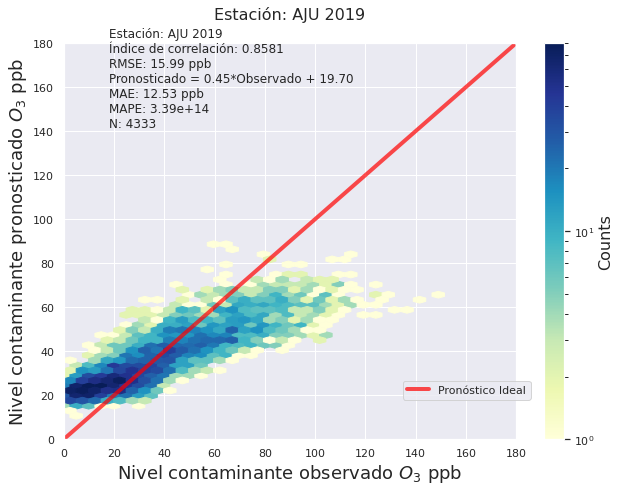

column name:plus_24_cont_otres_AJU
Índice de correlación:                     0.8520


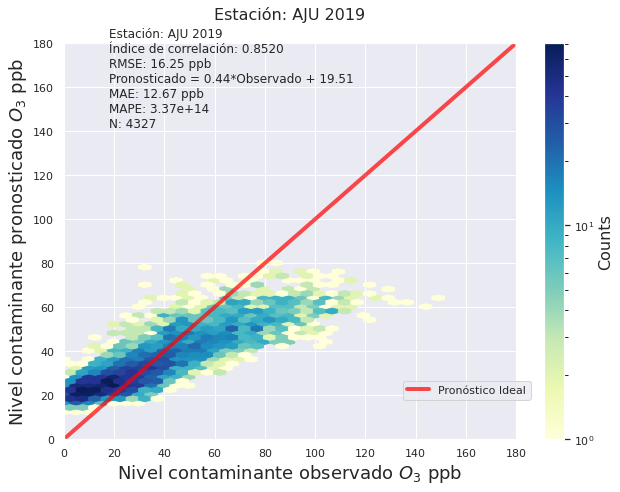

column name:plus_01_cont_otres_ATI
Índice de correlación:                     0.9268


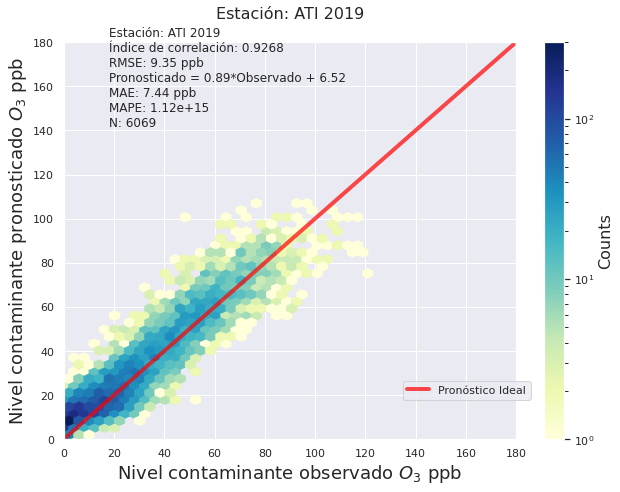

column name:plus_06_cont_otres_ATI
Índice de correlación:                     0.8846


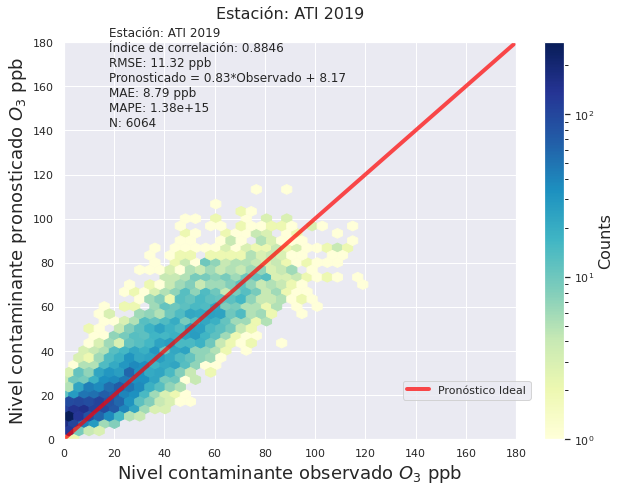

column name:plus_12_cont_otres_ATI
Índice de correlación:                     0.8793


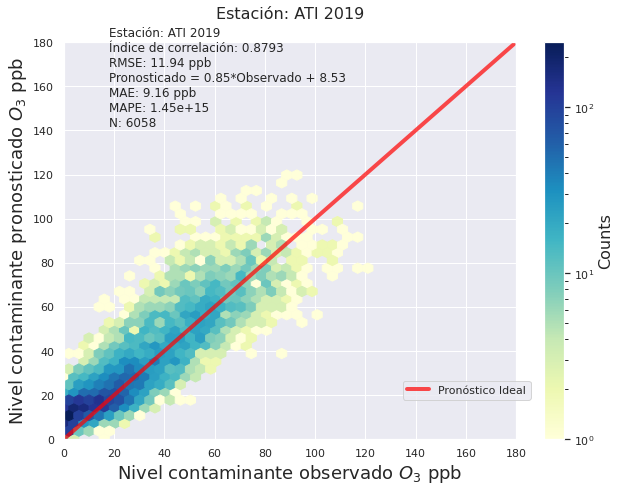

column name:plus_18_cont_otres_ATI
Índice de correlación:                     0.8877


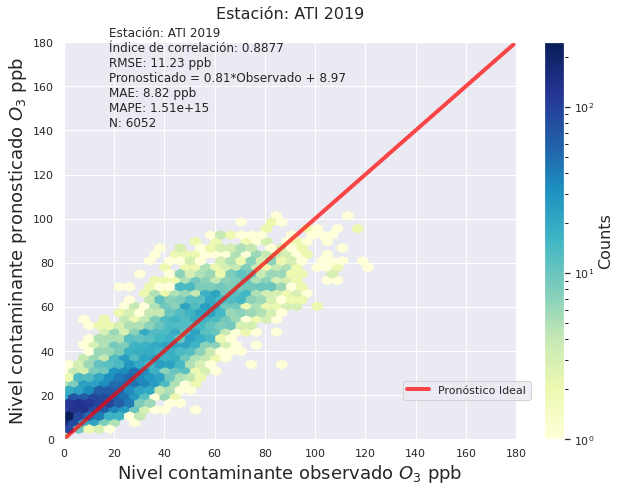

column name:plus_24_cont_otres_ATI
Índice de correlación:                     0.8764


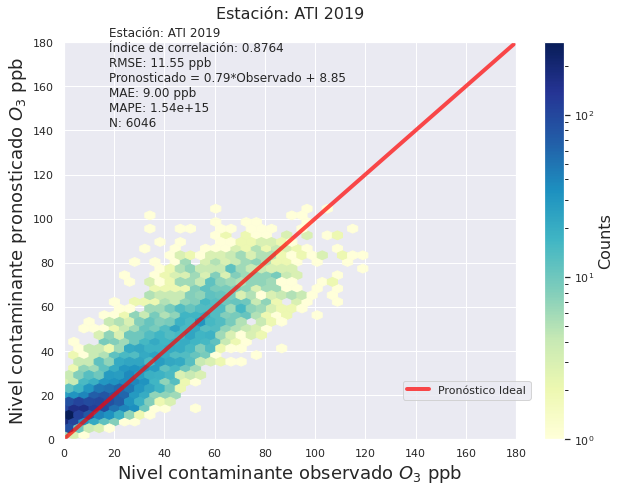

column name:plus_01_cont_otres_UAX
Índice de correlación:                     0.9086


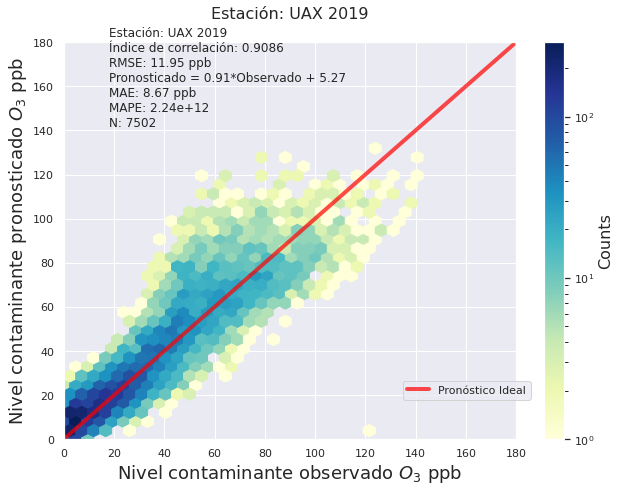

column name:plus_06_cont_otres_UAX
Índice de correlación:                     0.8786


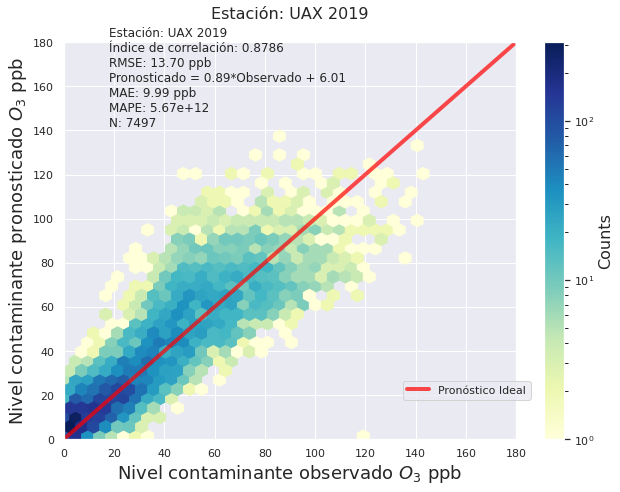

column name:plus_12_cont_otres_UAX
Índice de correlación:                     0.8693


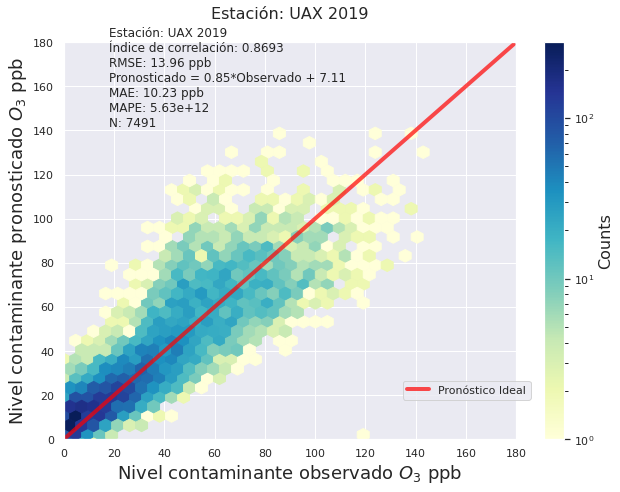

column name:plus_18_cont_otres_UAX
Índice de correlación:                     0.8734


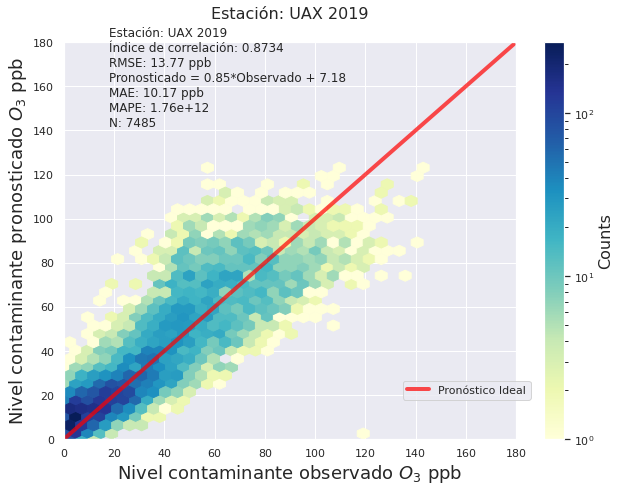

column name:plus_24_cont_otres_UAX
Índice de correlación:                     0.8563


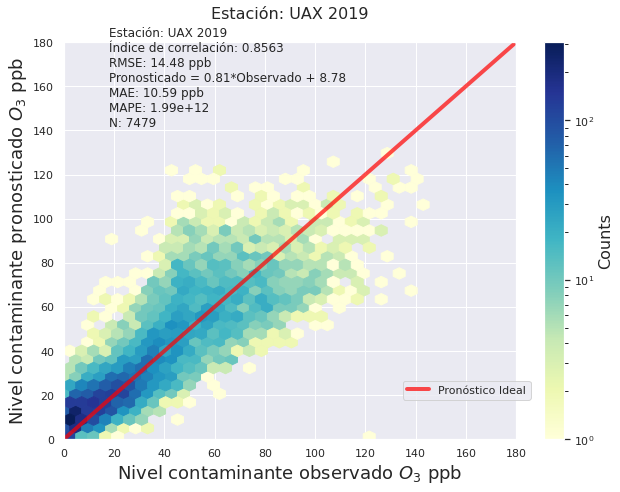

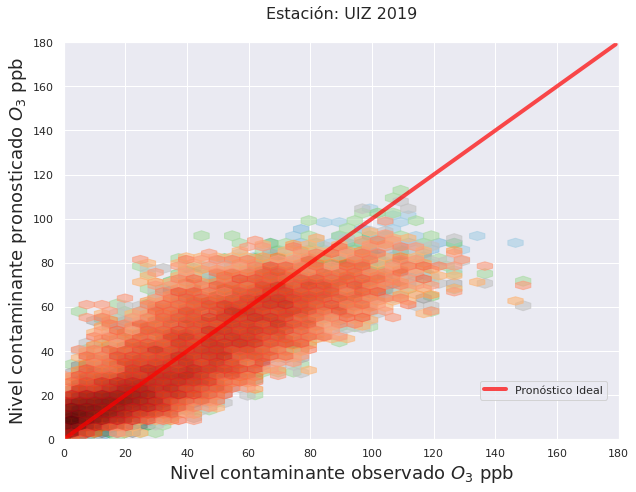

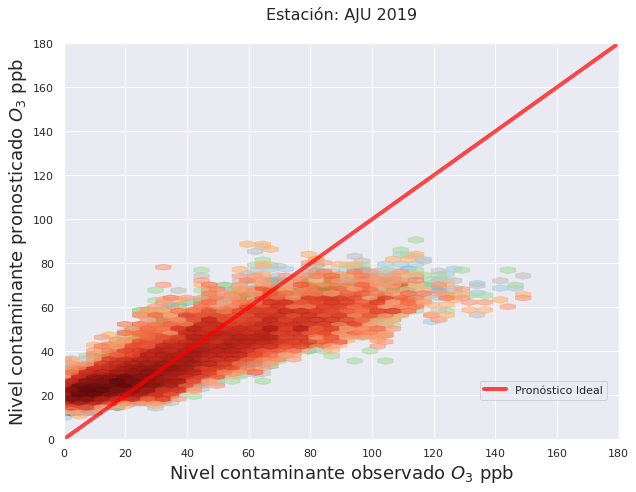

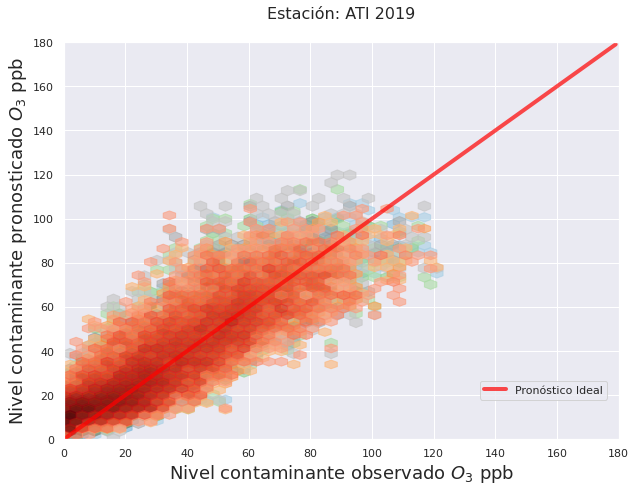

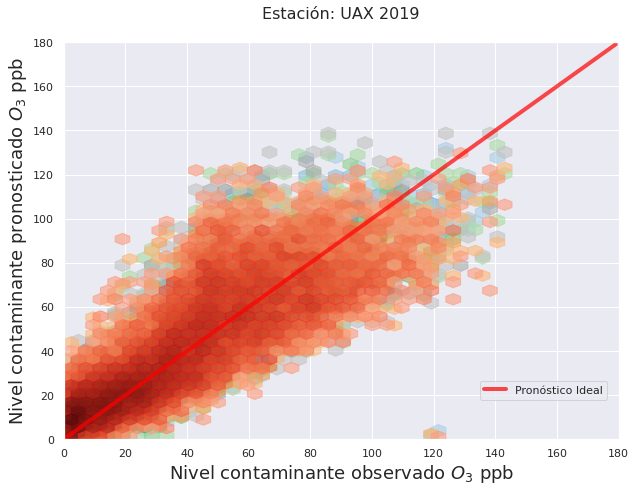

In [34]:
# %% *********** Chooses the proper model and weights ***********

# %% Loading csv with X an Y columns
X_cols_csv = pd.read_csv( join(path_csvs, 'X_columns.csv'))
Y_cols_csv = pd.read_csv( join(path_csvs, 'Y_columns.csv'))

X_cols = X_cols_csv['0'].tolist()
Y_cols = Y_cols_csv['0'].tolist()


# %% ******************* Selecting the model **********************

config[ModelParams.INPUT_SIZE] = INPUT_SIZE
config[ModelParams.NUMBER_OF_OUTPUT_CLASSES] = len(Y_cols)

print('Reading model ....')
model = select_1d_model(config)


# *********** Reads the weights***********
print('Reading weights ....')
model.load_weights(model_weights_file)


# %% Computing predictions of test dataset:
Y_pred = model.predict(X_df.values)

# %% A funciton is defined to generate custom scaler objects
scaler_y = compile_scaler(scaler,Y_cols)


#%% Descale predictions and y_true, and their processing
Y_pred_descaled = scaler_y.inverse_transform(Y_pred)
y_pred_descaled_df = pd.DataFrame(Y_pred_descaled,
                                  columns=scaler_y.feature_names_in_)

print(y_pred_descaled_df.head())

y_true_df = pd.DataFrame(scaler_y.inverse_transform(Y_df),
                         columns=Y_df.columns)
print(y_true_df.head())

# %% Evaluating only a set of stations and hours
for station in evaluate_stations:
    for hour in evaluate_hours:
        cur_column = f'plus_{hour:02}_cont_otres_{station}'
        print(f'column name:{cur_column}')
        # analyze_column(cur_column)
        analyze_column(cur_column,
                       y_pred_descaled_df,
                       y_true_df,
                       test_year=test_year,
                       output_results_folder_img=output_results_folder_img)

for station in evaluate_stations:
    analyze_multi_hour_plot(
        station,
        evaluate_hours,
        y_pred_descaled_df,
        y_true_df,
        test_year=test_year,
        output_results_folder_img=output_results_folder_img)



In [35]:
#Saving results data for further analysis

print(f'output_results_folder: \n\n {output_results_folder}\n')
y_pred_descaled_df.to_csv(f'{output_results_folder}/{string_test}_y_pred_descaled.csv')
y_true_df.to_csv(f'{output_results_folder}/{string_test}_y_true_descaled.csv')

output_results_folder: 

 /ZION/AirPollutionData/Data/Results/TestOZ/TestOZ_otres_2024_01_19_22_05



In [36]:
# %% #Create DataFrame with metric results and save the results in a csv file

results_df = pd.DataFrame(columns=[
    "Columna", "Índice de correlación", "MAE", "MAPE", "MSE", "RMSE", "R2"
])

for cur_column in y_pred_descaled_df.columns:
    print(cur_column)
    column_results = analyze_column(cur_column,
                                    y_pred_descaled_df,
                                    y_true_df,
                                    test_year=test_year,
                                    generate_plot=False)
    results_df = results_df.append(column_results, ignore_index=True)

print(results_df)
results_df.to_csv(join(output_results_folder_data, 'results_df.csv'),
                  index=False)


plus_01_cont_otres_UIZ
Índice de correlación:                     0.9352
plus_01_cont_otres_AJU
Índice de correlación:                     0.9026
plus_01_cont_otres_ATI
Índice de correlación:                     0.9268
plus_01_cont_otres_CUA
Índice de correlación:                     0.8840
plus_01_cont_otres_SFE
Índice de correlación:                     0.9006
plus_01_cont_otres_SAG
Índice de correlación:                     0.9438
plus_01_cont_otres_CUT
Índice de correlación:                     0.9406
plus_01_cont_otres_PED
Índice de correlación:                     0.9387
plus_01_cont_otres_TAH
Índice de correlación:                     0.9201
plus_01_cont_otres_GAM
Índice de correlación:                     0.9350
plus_01_cont_otres_IZT
Índice de correlación:                     0.9521
plus_01_cont_otres_CCA
Índice de correlación:                     0.9407
plus_01_cont_otres_HGM
Índice de correlación:                     0.9411
plus_01_cont_otres_LPR
Índice de correlación:      

Índice de correlación:                     0.8379
plus_05_cont_otres_MON
Índice de correlación:                     0.8963
plus_05_cont_otres_NEZ
Índice de correlación:                     0.9000
plus_05_cont_otres_INN
Índice de correlación:                     0.8048
plus_05_cont_otres_AJM
Índice de correlación:                     0.8407
plus_05_cont_otres_VIF
Índice de correlación:                     0.8720
plus_06_cont_otres_UIZ
Índice de correlación:                     0.8965
plus_06_cont_otres_AJU
Índice de correlación:                     0.8626
plus_06_cont_otres_ATI
Índice de correlación:                     0.8846
plus_06_cont_otres_CUA
Índice de correlación:                     0.8271
plus_06_cont_otres_SFE
Índice de correlación:                     0.8427
plus_06_cont_otres_SAG
Índice de correlación:                     0.9053
plus_06_cont_otres_CUT
Índice de correlación:                     0.9082
plus_06_cont_otres_PED
Índice de correlación:                     0.8874
p

Índice de correlación:                     0.8683
plus_10_cont_otres_BJU
Índice de correlación:                     0.8784
plus_10_cont_otres_MPA
Índice de correlación:                     0.8272
plus_10_cont_otres_MON
Índice de correlación:                     0.8957
plus_10_cont_otres_NEZ
Índice de correlación:                     0.8923
plus_10_cont_otres_INN
Índice de correlación:                     0.7955
plus_10_cont_otres_AJM
Índice de correlación:                     0.8349
plus_10_cont_otres_VIF
Índice de correlación:                     0.8629
plus_11_cont_otres_UIZ
Índice de correlación:                     0.8961
plus_11_cont_otres_AJU
Índice de correlación:                     0.8703
plus_11_cont_otres_ATI
Índice de correlación:                     0.8798
plus_11_cont_otres_CUA
Índice de correlación:                     0.8128
plus_11_cont_otres_SFE
Índice de correlación:                     0.8473
plus_11_cont_otres_SAG
Índice de correlación:                     0.9051
p

plus_14_cont_otres_NEZ
Índice de correlación:                     0.8944
plus_14_cont_otres_INN
Índice de correlación:                     0.7930
plus_14_cont_otres_AJM
Índice de correlación:                     0.8256
plus_14_cont_otres_VIF
Índice de correlación:                     0.8432
plus_15_cont_otres_UIZ
Índice de correlación:                     0.8935
plus_15_cont_otres_AJU
Índice de correlación:                     0.8570
plus_15_cont_otres_ATI
Índice de correlación:                     0.8773
plus_15_cont_otres_CUA
Índice de correlación:                     0.8169
plus_15_cont_otres_SFE
Índice de correlación:                     0.8397
plus_15_cont_otres_SAG
Índice de correlación:                     0.9076
plus_15_cont_otres_CUT
Índice de correlación:                     0.9023
plus_15_cont_otres_PED
Índice de correlación:                     0.8844
plus_15_cont_otres_TAH
Índice de correlación:                     0.8777
plus_15_cont_otres_GAM
Índice de correlación:      

plus_19_cont_otres_MPA
Índice de correlación:                     0.8253
plus_19_cont_otres_MON
Índice de correlación:                     0.8959
plus_19_cont_otres_NEZ
Índice de correlación:                     0.8935
plus_19_cont_otres_INN
Índice de correlación:                     0.7887
plus_19_cont_otres_AJM
Índice de correlación:                     0.8291
plus_19_cont_otres_VIF
Índice de correlación:                     0.8672
plus_20_cont_otres_UIZ
Índice de correlación:                     0.8914
plus_20_cont_otres_AJU
Índice de correlación:                     0.8537
plus_20_cont_otres_ATI
Índice de correlación:                     0.8916
plus_20_cont_otres_CUA
Índice de correlación:                     0.8169
plus_20_cont_otres_SFE
Índice de correlación:                     0.8447
plus_20_cont_otres_SAG
Índice de correlación:                     0.9017
plus_20_cont_otres_CUT
Índice de correlación:                     0.9118
plus_20_cont_otres_PED
Índice de correlación:      

Índice de correlación:                     0.8881
plus_24_cont_otres_XAL
Índice de correlación:                     0.8771
plus_24_cont_otres_LLA
Índice de correlación:                     0.8954
plus_24_cont_otres_TLI
Índice de correlación:                     0.8921
plus_24_cont_otres_UAX
Índice de correlación:                     0.8563
plus_24_cont_otres_BJU
Índice de correlación:                     0.8697
plus_24_cont_otres_MPA
Índice de correlación:                     0.8130
plus_24_cont_otres_MON
Índice de correlación:                     0.8901
plus_24_cont_otres_NEZ
Índice de correlación:                     0.8817
plus_24_cont_otres_INN
Índice de correlación:                     0.7790
plus_24_cont_otres_AJM
Índice de correlación:                     0.8153
plus_24_cont_otres_VIF
Índice de correlación:                     0.8533
                    Columna  Índice de correlación        MAE          MAPE  \
0    plus_01_cont_otres_UIZ               0.935202   7.211486  3.836

In [37]:
results_df
# Extract unique station identifiers from the "Columna" column
station_identifiers = results_df['Columna'].str.split('_').str[4].unique()
station_identifiers

array(['UIZ', 'AJU', 'ATI', 'CUA', 'SFE', 'SAG', 'CUT', 'PED', 'TAH',
       'GAM', 'IZT', 'CCA', 'HGM', 'LPR', 'MGH', 'CAM', 'FAC', 'TLA',
       'MER', 'XAL', 'LLA', 'TLI', 'UAX', 'BJU', 'MPA', 'MON', 'NEZ',
       'INN', 'AJM', 'VIF'], dtype=object)

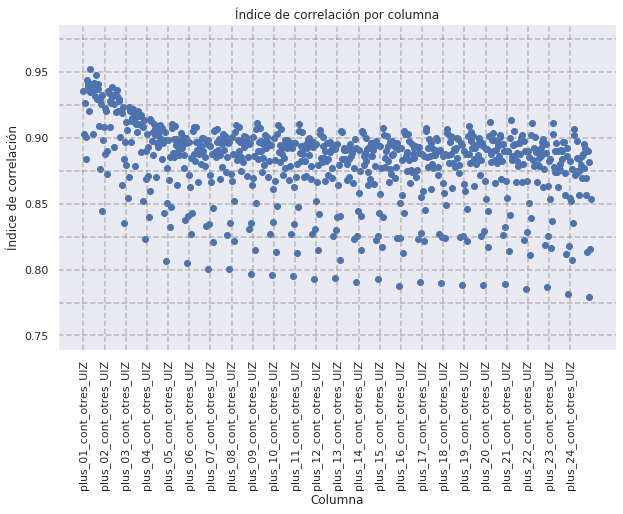

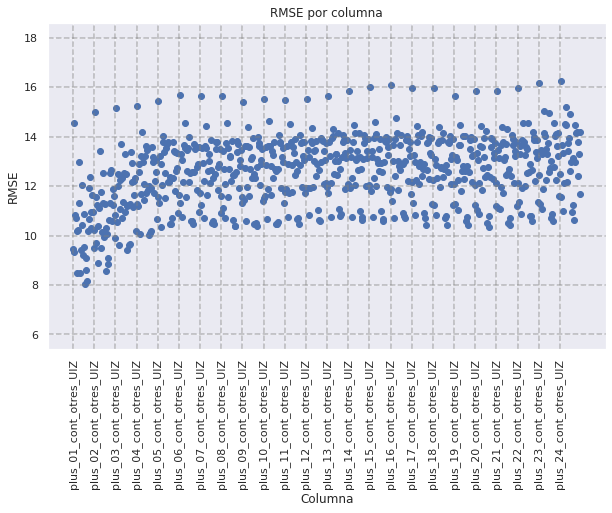

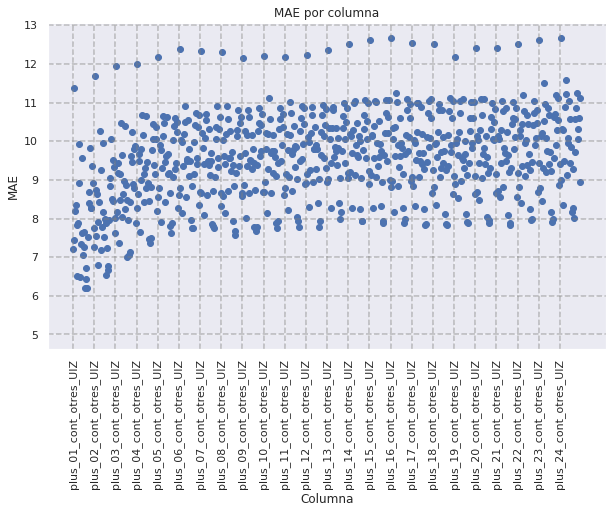

In [38]:
# %% Scatter plot for the given metrics

scatter_plot_by_column(results_df, 'Índice de correlación',
                output_results_folder_img)
scatter_plot_by_column(results_df, 'RMSE', output_results_folder_img)
scatter_plot_by_column(results_df, 'MAE', output_results_folder_img)


Promedio general de Índice de correlación sobre todas las estaciones: 0.8810


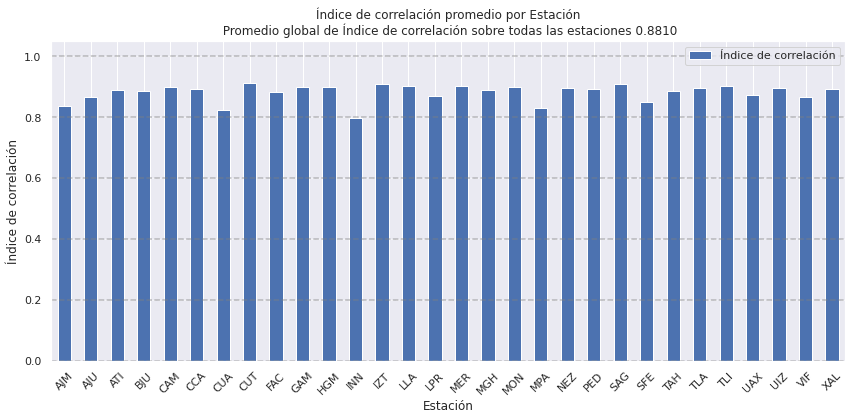

Promedio general de RMSE sobre todas las estaciones: 12.5558


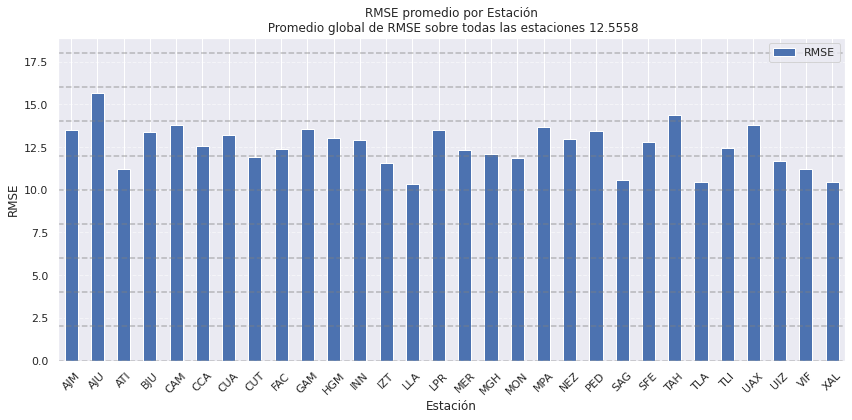

Promedio general de MAE sobre todas las estaciones: 9.5449


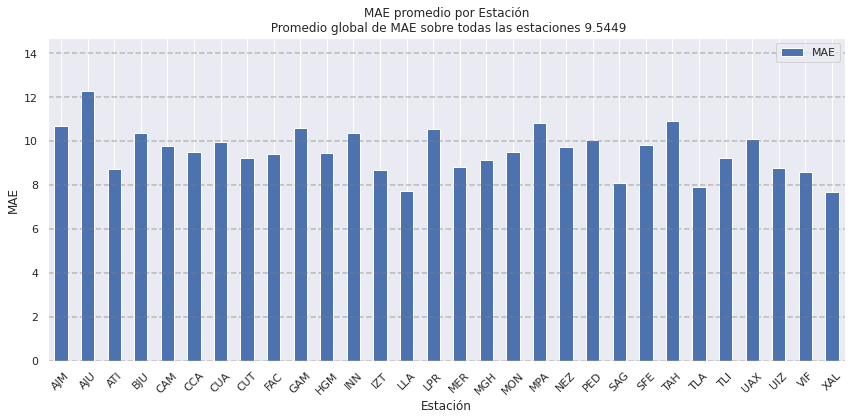

In [39]:
# %% Llamada a función para graficar las métricas de resumen de todas horas por estacion

average_metric(results_df, 'Índice de correlación', output_results_folder_img)
average_metric(results_df, 'RMSE', output_results_folder_img)
average_metric(results_df, 'MAE', output_results_folder_img)

Promedio general de Índice de correlación sobre todas las horas: 0.8810


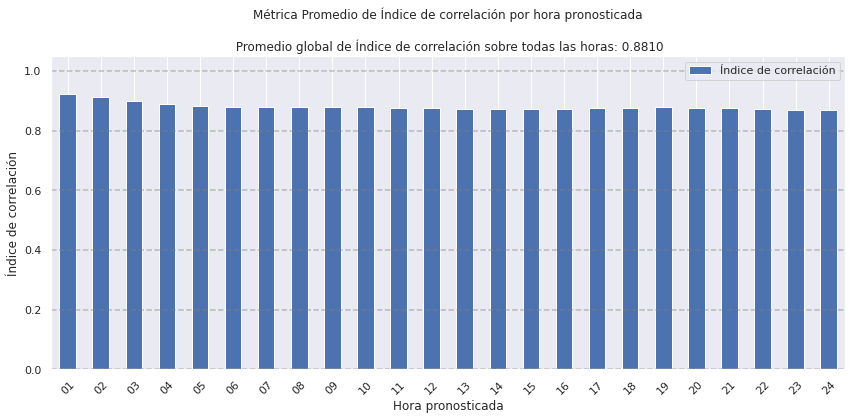

Promedio general de RMSE sobre todas las horas: 12.5558


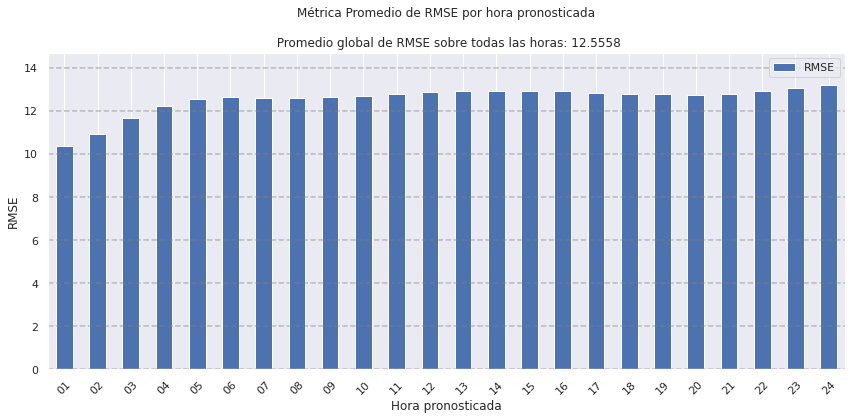

Promedio general de MAE sobre todas las horas: 9.5449


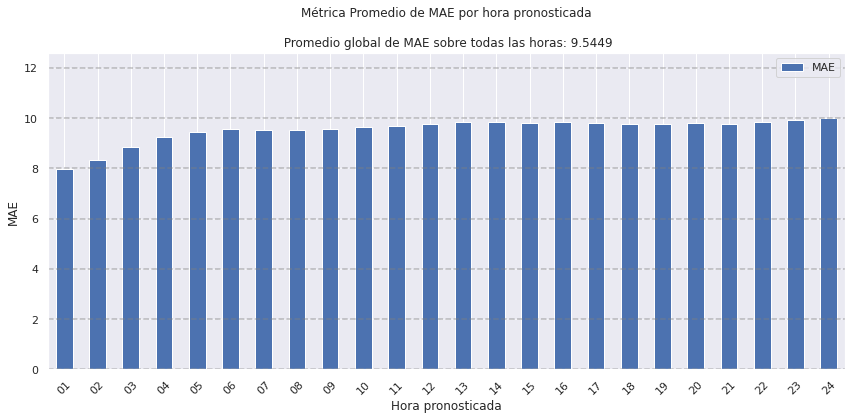

In [40]:
# %% Llamada a función para graficar las métricas de resumen de todas las estaciones por hora
average_metric_by_hour(results_df, 'Índice de correlación', output_results_folder_img)
average_metric_by_hour(results_df, 'RMSE', output_results_folder_img)
average_metric_by_hour(results_df, 'MAE', output_results_folder_img)

In [41]:
# %% 
params_grid = [(f'plus_{hour:02}_cont_{cur_pollutant}_{cur_station}')
               for cur_station in evaluate_stations for hour in evaluate_hours]


plus_01_cont_otres_UIZ


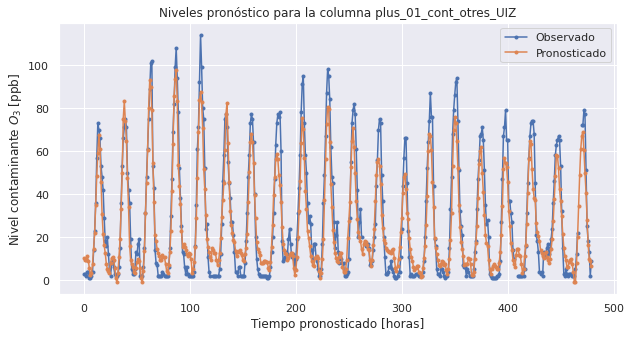

plus_06_cont_otres_UIZ


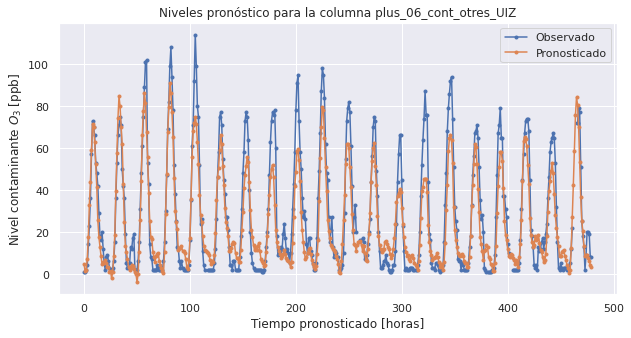

plus_12_cont_otres_UIZ


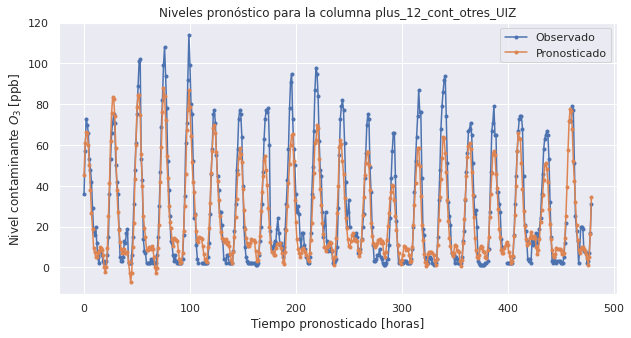

plus_18_cont_otres_UIZ


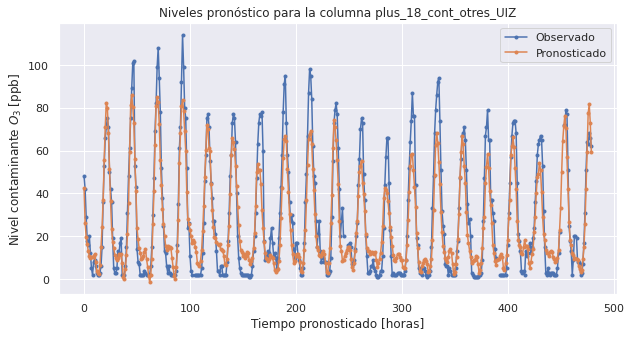

plus_24_cont_otres_UIZ


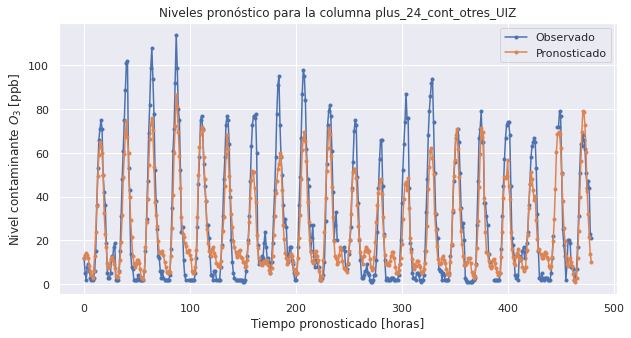

plus_01_cont_otres_AJU


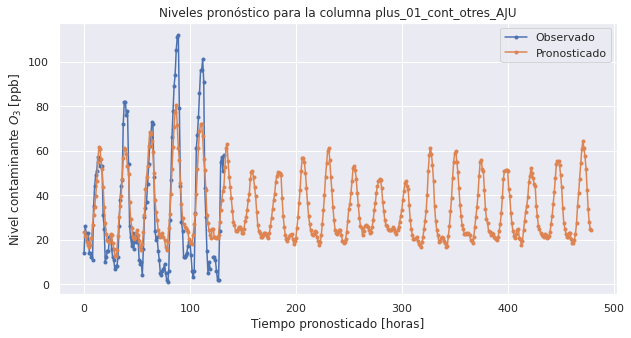

plus_06_cont_otres_AJU


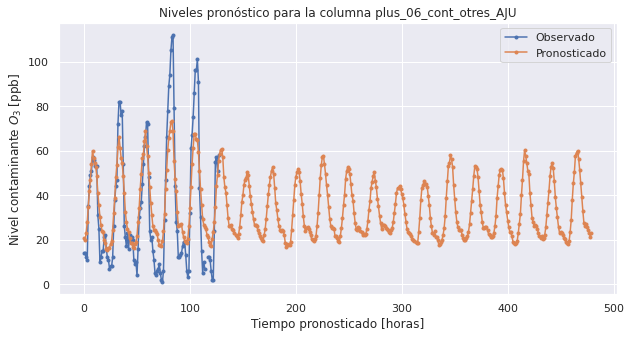

plus_12_cont_otres_AJU


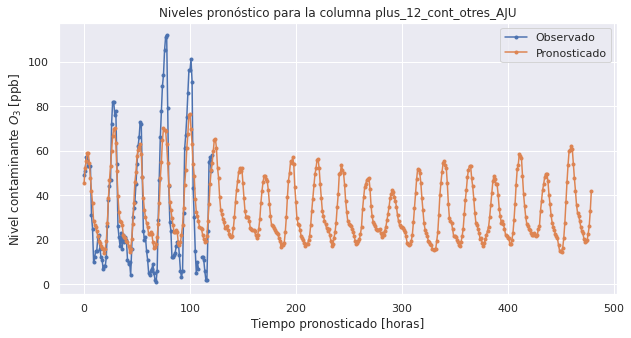

plus_18_cont_otres_AJU


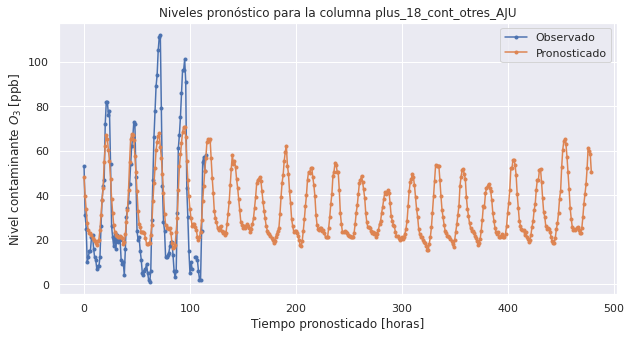

plus_24_cont_otres_AJU


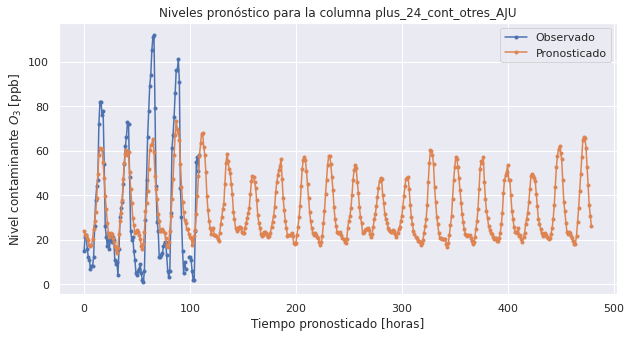

plus_01_cont_otres_ATI


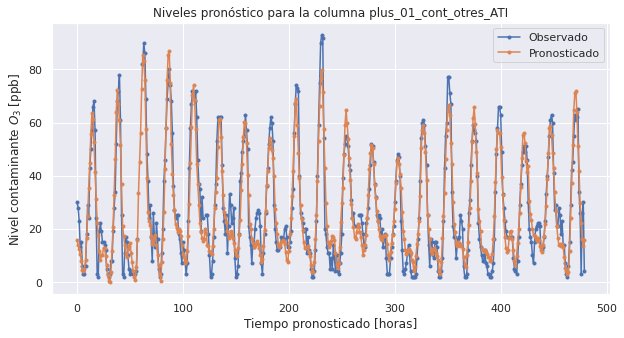

plus_06_cont_otres_ATI


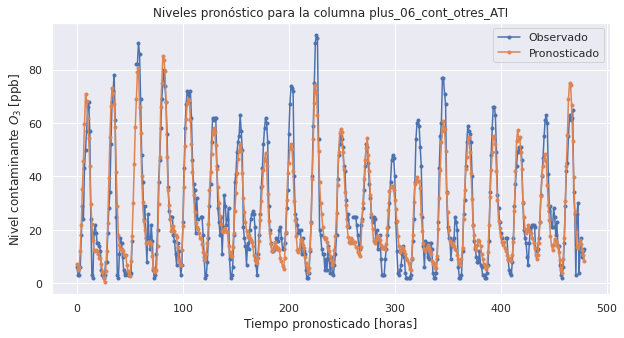

plus_12_cont_otres_ATI


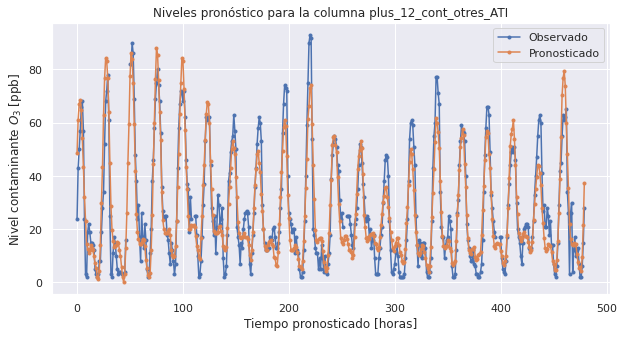

plus_18_cont_otres_ATI


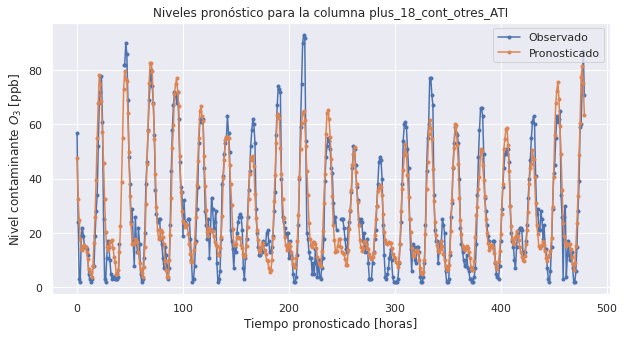

plus_24_cont_otres_ATI


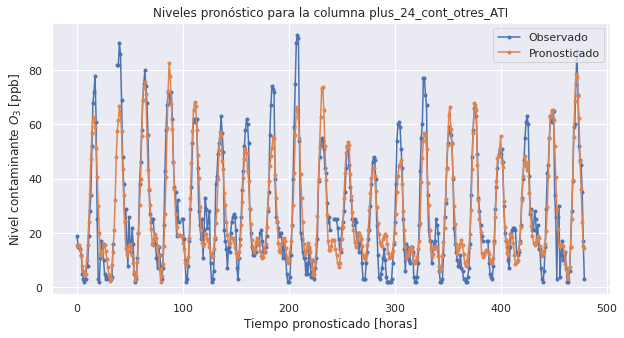

plus_01_cont_otres_UAX


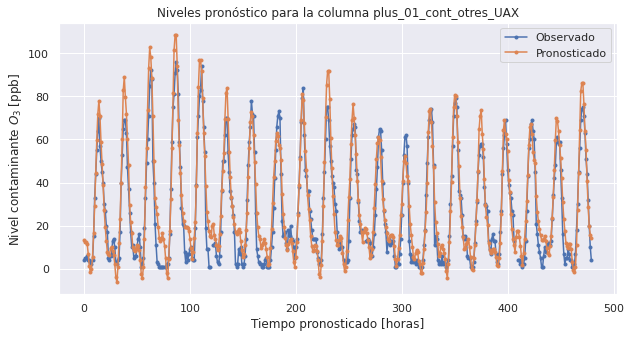

plus_06_cont_otres_UAX


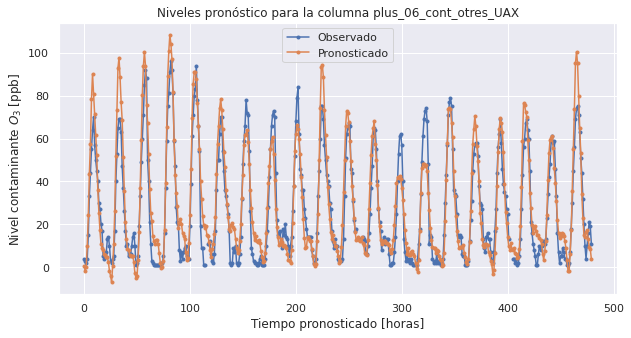

plus_12_cont_otres_UAX


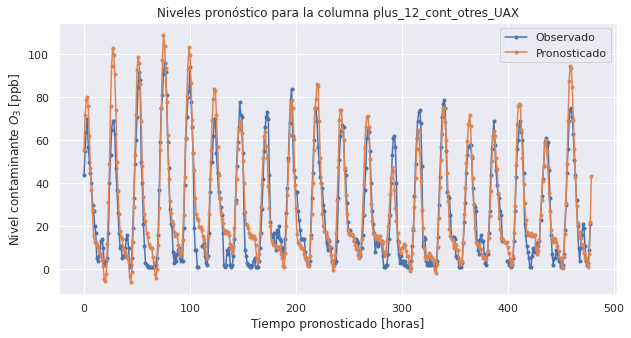

plus_18_cont_otres_UAX


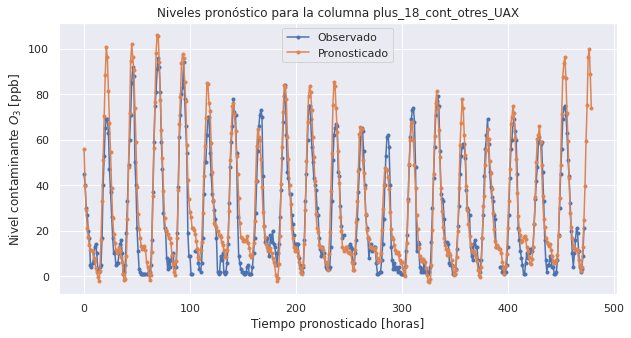

plus_24_cont_otres_UAX


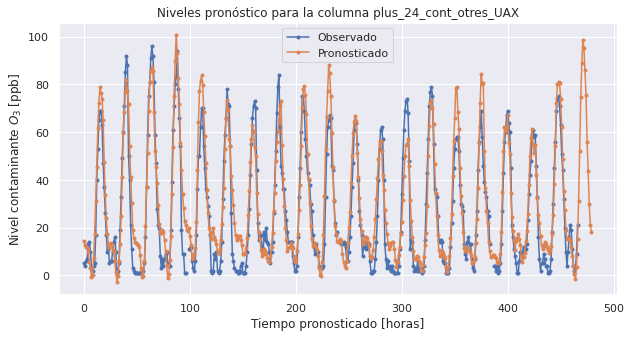

In [42]:
# %% #Hacer gráficas de horas de algunos casos
for cur_column in params_grid:
    print(cur_column)
    # Llamar a la función con la columna deseada
    plot_forecast_hours(cur_column, y_true_df,
                        y_pred_descaled_df)  # , path_home)

plus_01_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 3.593998202631029
Desviación estándar de diferencia en valores máximos diarios: 13.371078024403479


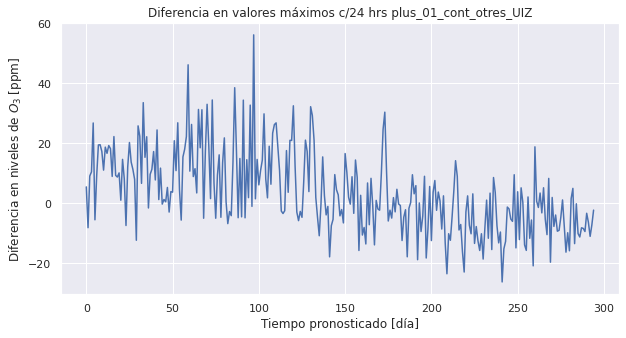

plus_06_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 5.904121043318409
Desviación estándar de diferencia en valores máximos diarios: 16.669925103397485


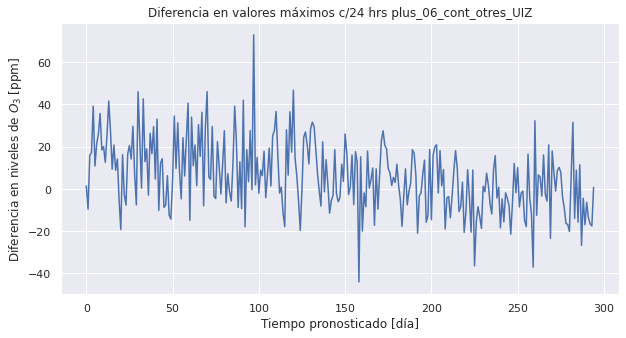

plus_12_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 8.696413352736661
Desviación estándar de diferencia en valores máximos diarios: 16.033057851766312


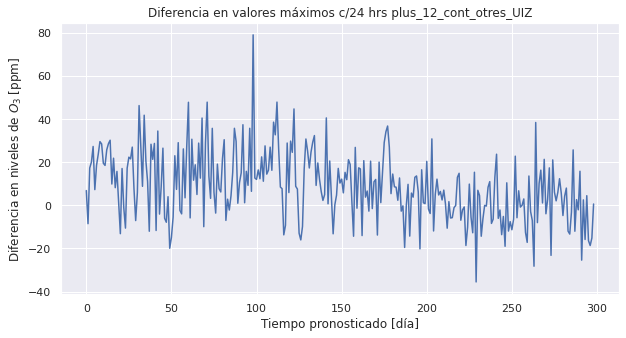

plus_18_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 6.684927379762804
Desviación estándar de diferencia en valores máximos diarios: 17.200116285321954


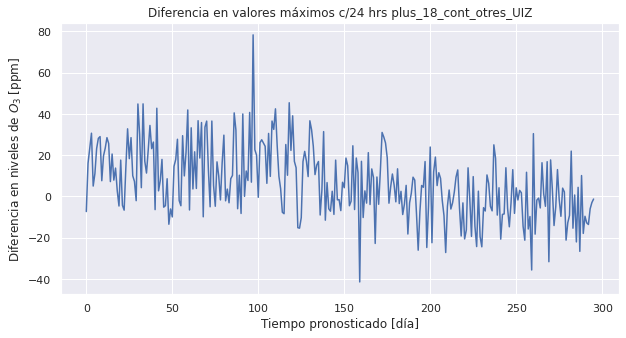

plus_24_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 7.606744085039411
Desviación estándar de diferencia en valores máximos diarios: 17.4722801643362


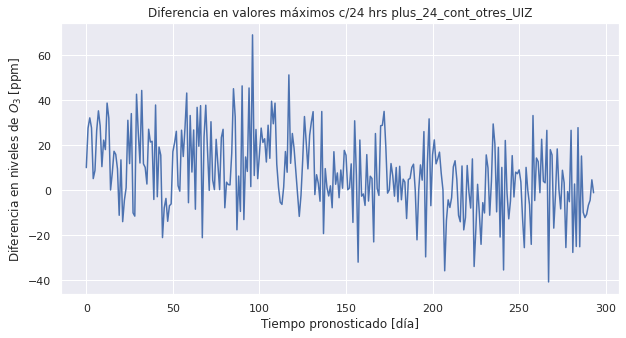

plus_01_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 17.65379271356229
Desviación estándar de diferencia en valores máximos diarios: 18.218609421874678


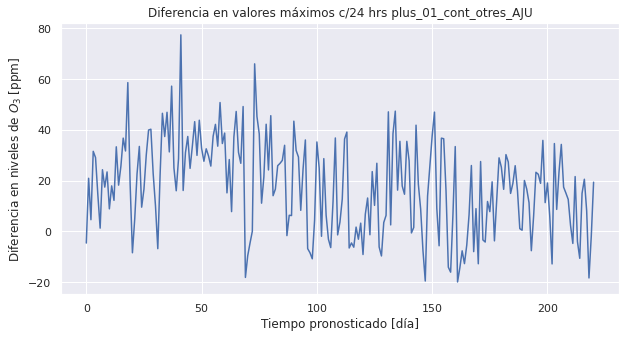

plus_06_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 16.874486124193346
Desviación estándar de diferencia en valores máximos diarios: 19.658376152917118


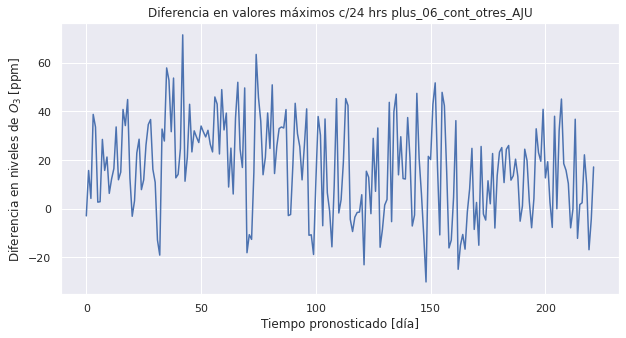

plus_12_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 17.81337341102394
Desviación estándar de diferencia en valores máximos diarios: 18.419927413902073


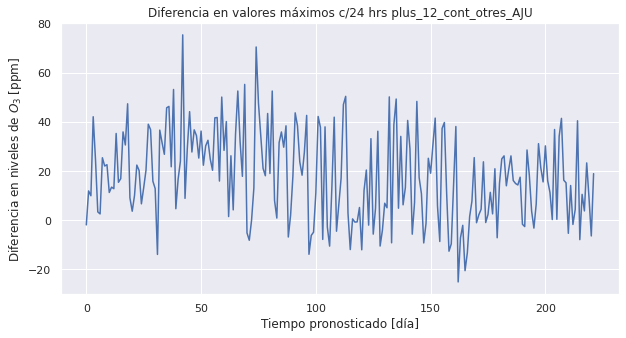

plus_18_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 19.156721445719402
Desviación estándar de diferencia en valores máximos diarios: 19.779055923360414


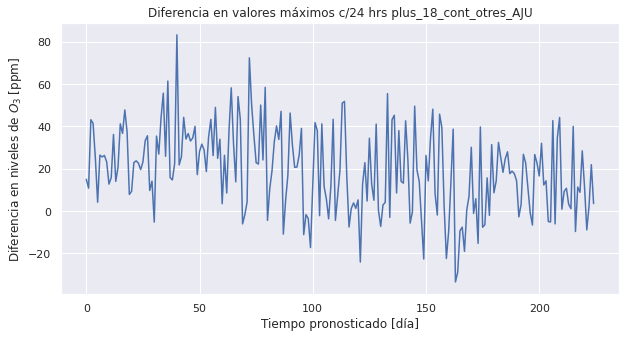

plus_24_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 19.09249467719091
Desviación estándar de diferencia en valores máximos diarios: 20.719877577137343


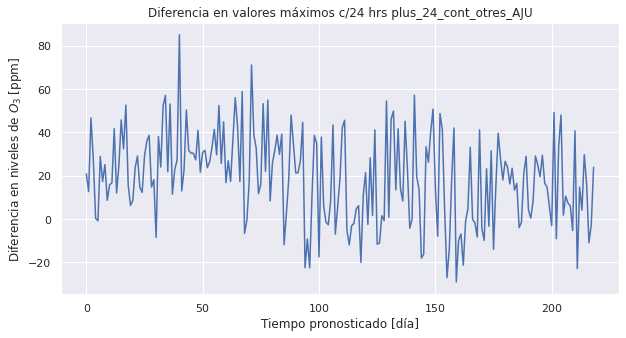

plus_01_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: -2.9574971993764243
Desviación estándar de diferencia en valores máximos diarios: 11.057166211707866


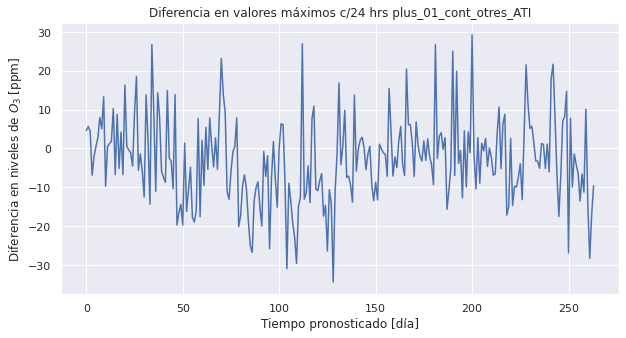

plus_06_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: -1.6067128432424445
Desviación estándar de diferencia en valores máximos diarios: 15.031765865970245


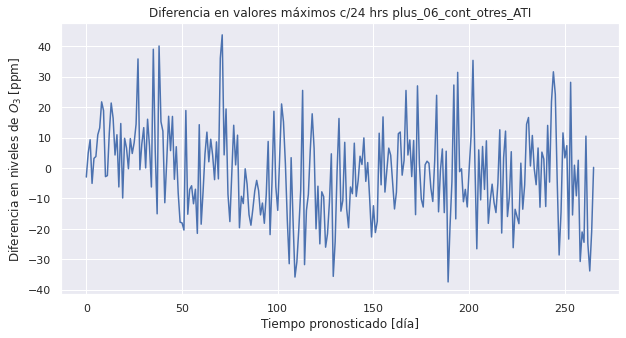

plus_12_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: -2.8382642717289746
Desviación estándar de diferencia en valores máximos diarios: 15.821697490494428


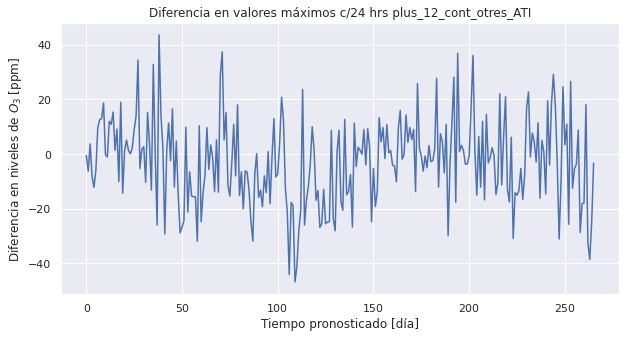

plus_18_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: -0.2663134808810252
Desviación estándar de diferencia en valores máximos diarios: 13.966872592755049


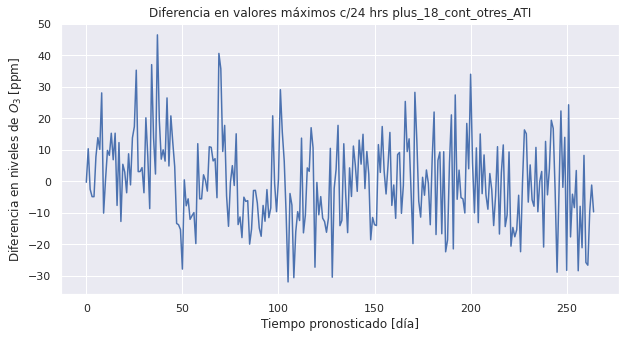

plus_24_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: -0.29886740558552294
Desviación estándar de diferencia en valores máximos diarios: 15.68868863441711


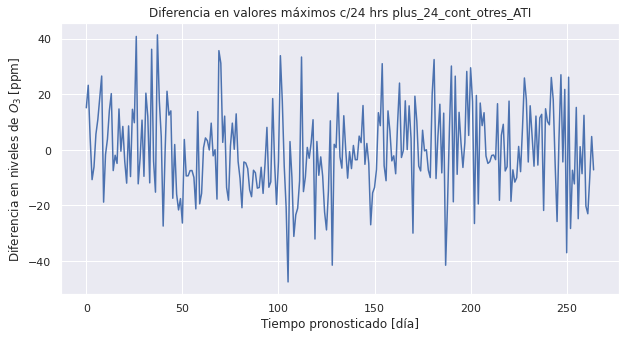

plus_01_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: -1.415676787092879
Desviación estándar de diferencia en valores máximos diarios: 19.347679489545907


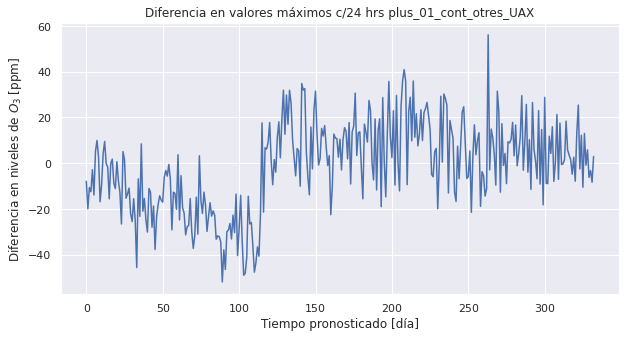

plus_06_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: -2.001538396595481
Desviación estándar de diferencia en valores máximos diarios: 21.93298006018087


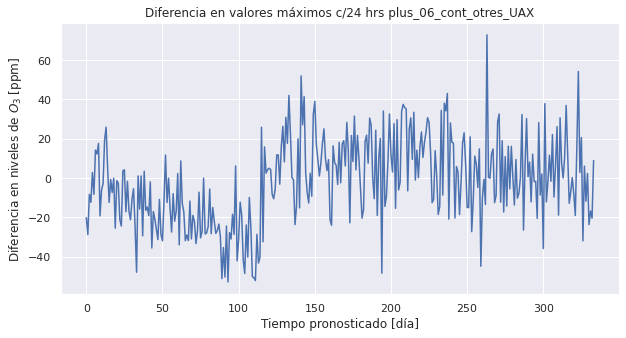

plus_12_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: -0.04883491425287156
Desviación estándar de diferencia en valores máximos diarios: 21.868285403612884


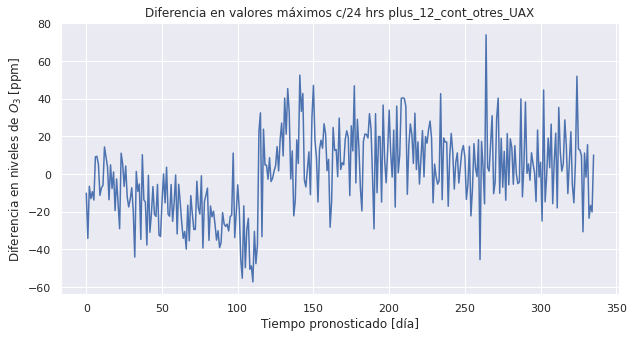

plus_18_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: -1.017153286072145
Desviación estándar de diferencia en valores máximos diarios: 21.675603864345863


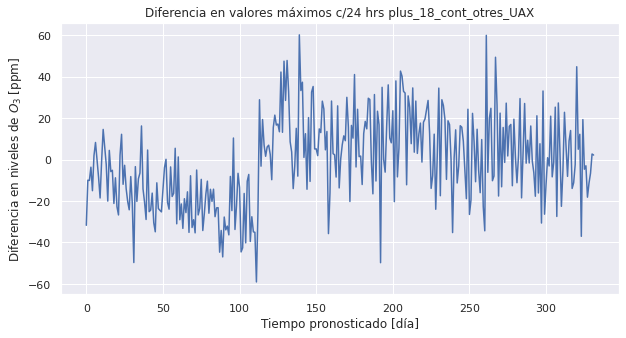

plus_24_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: 1.0781207343962977
Desviación estándar de diferencia en valores máximos diarios: 23.613873390504263


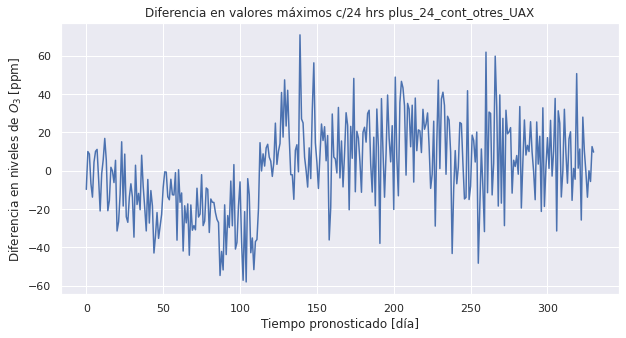

Promedio de h24_max_err_mean: 5.585216729237337
Promedio de h24_max_err_std: 17.877345846097572


In [43]:
# %% Calculo de valores máximos por cada 24 horas. 
# Crear un DataFrame vacío

results_max_df = pd.DataFrame(columns=[
    'max_y_true', 'max_y_pred', 'h24_max_err_mean', 'h24_max_err_std'
])

# Rellenar el DataFrame con los resultados de la función
for cur_column in params_grid:
    print(cur_column)
    max_y_true, max_y_pred, h24_max_err_mean, h24_max_err_std = plot_max_difference(
        cur_column, y_true_df, y_pred_descaled_df)
    results_max_df = results_max_df.append(
        {
            'max_y_true': max_y_true,
            'max_y_pred': max_y_pred,
            'h24_max_err_mean': h24_max_err_mean,
            'h24_max_err_std': h24_max_err_std
        },
        ignore_index=True)

# Calcular el promedio de las cuatro columnas
average_h24_max_err_mean = results_max_df['h24_max_err_mean'].mean()
average_h24_max_err_std = results_max_df['h24_max_err_std'].mean()

print("Promedio de h24_max_err_mean:", average_h24_max_err_mean)
print("Promedio de h24_max_err_std:", average_h24_max_err_std)


In [44]:
# Inicializar nuevas columnas para almacenar los resultados adicionales
results_df['h24_max_err_mean'] = 0.0
results_df['h24_max_err_std'] = 0.0
results_df['h24_mean_err_mean'] = 0.0
results_df['h24_mean_err_std'] = 0.0
errors_dict = {}

# Iterar a través de cada fila en el DataFrame para actualizar las nuevas columnas
for index, row in results_df.iterrows():
    cur_column = row['Columna']
    # Llamar a la función plot_max_and_mean_difference y obtener los resultados
    max_y_true, max_y_pred, h24_max_err_mean, h24_max_err_std, mean_y_true, mean_y_pred, h24_mean_err_mean, h24_mean_err_std = plot_max_and_mean_difference(cur_column, y_true_df, y_pred_descaled_df)
    
    # Actualizar las nuevas columnas con los resultados obtenidos
    results_df.loc[index, 'h24_max_err_mean'] = h24_max_err_mean
    results_df.loc[index, 'h24_max_err_std'] = h24_max_err_std
    results_df.loc[index, 'h24_mean_err_mean'] = h24_mean_err_mean
    results_df.loc[index, 'h24_mean_err_std'] = h24_mean_err_std
    # Almacenar max_y_true, max_y_pred, mean_y_true, y mean_y_pred en el diccionario errors_dict
    errors_dict[cur_column] = {
        'max_y_true': max_y_true,
        'max_y_pred': max_y_pred,
        'mean_y_true': mean_y_true,
        'mean_y_pred': mean_y_pred
    }
# Ahora, results_df debería tener las nuevas columnas llenas con los resultados de la función

plus_01_cont_otres_UIZ
Maximum error mean over 24 hrs: 3.593998202631029
Maximum error std dev over 24 hrs: 13.371078024403479
Mean error mean over 24 hrs: 0.015692936313354555
Mean error std dev over 24 hrs: 4.6245912960817535
plus_01_cont_otres_AJU
Maximum error mean over 24 hrs: 17.65379271356229
Maximum error std dev over 24 hrs: 18.218609421874678
Mean error mean over 24 hrs: 1.0340301220952839
Mean error std dev over 24 hrs: 5.810974184588909
plus_01_cont_otres_ATI
Maximum error mean over 24 hrs: -2.9574971993764243
Maximum error std dev over 24 hrs: 11.057166211707866
Mean error mean over 24 hrs: -3.3162168396843805
Mean error std dev over 24 hrs: 3.555198887013912
plus_01_cont_otres_CUA
Maximum error mean over 24 hrs: -0.4741168887883167
Maximum error std dev over 24 hrs: 16.636617999209722
Mean error mean over 24 hrs: 0.516602969421548
Mean error std dev over 24 hrs: 5.160633248028043
plus_01_cont_otres_SFE
Maximum error mean over 24 hrs: -0.5809225785104852
Maximum error std 

plus_04_cont_otres_CUT
Maximum error mean over 24 hrs: 9.635113486487198
Maximum error std dev over 24 hrs: 15.082582175304704
Mean error mean over 24 hrs: -0.49549517415400623
Mean error std dev over 24 hrs: 4.538586194175649
plus_04_cont_otres_PED
Maximum error mean over 24 hrs: 1.3387443609209868
Maximum error std dev over 24 hrs: 17.771469100202438
Mean error mean over 24 hrs: 1.5100586754935128
Mean error std dev over 24 hrs: 4.742740809467011
plus_04_cont_otres_TAH
Maximum error mean over 24 hrs: 16.803198257402816
Maximum error std dev over 24 hrs: 17.541106985878
Mean error mean over 24 hrs: 2.5462067027603688
Mean error std dev over 24 hrs: 5.644391228727726
plus_04_cont_otres_GAM
Maximum error mean over 24 hrs: 8.305602382373259
Maximum error std dev over 24 hrs: 16.50841833914536
Mean error mean over 24 hrs: -0.5216591184768608
Mean error std dev over 24 hrs: 5.09603522158249
plus_04_cont_otres_IZT
Maximum error mean over 24 hrs: 1.818116670274465
Maximum error std dev over 

plus_07_cont_otres_LPR
Maximum error mean over 24 hrs: -3.782992913689412
Maximum error std dev over 24 hrs: 19.043963621676447
Mean error mean over 24 hrs: -4.363200203129942
Mean error std dev over 24 hrs: 6.702809777332037
plus_07_cont_otres_MGH
Maximum error mean over 24 hrs: 1.0666131380587647
Maximum error std dev over 24 hrs: 18.231407199090064
Mean error mean over 24 hrs: -1.8478241415796082
Mean error std dev over 24 hrs: 5.946026955060281
plus_07_cont_otres_CAM
Maximum error mean over 24 hrs: 6.720837536980124
Maximum error std dev over 24 hrs: 20.822801939606002
Mean error mean over 24 hrs: 2.069090610236125
Mean error std dev over 24 hrs: 6.713933245902573
plus_07_cont_otres_FAC
Maximum error mean over 24 hrs: 6.885357419086921
Maximum error std dev over 24 hrs: 17.366614485678006
Mean error mean over 24 hrs: 1.6862926622738355
Mean error std dev over 24 hrs: 5.443881600674149
plus_07_cont_otres_TLA
Maximum error mean over 24 hrs: 4.344083388646443
Maximum error std dev ove

plus_10_cont_otres_GAM
Maximum error mean over 24 hrs: 10.085208837855447
Maximum error std dev over 24 hrs: 17.642374261292982
Mean error mean over 24 hrs: -0.2434602498321095
Mean error std dev over 24 hrs: 6.100107935567731
plus_10_cont_otres_IZT
Maximum error mean over 24 hrs: 3.3719810499271876
Maximum error std dev over 24 hrs: 15.499981295025059
Mean error mean over 24 hrs: -0.38924796125138866
Mean error std dev over 24 hrs: 4.930224191813705
plus_10_cont_otres_CCA
Maximum error mean over 24 hrs: 2.6830875632468234
Maximum error std dev over 24 hrs: 18.584194943221316
Mean error mean over 24 hrs: -1.4435326983866177
Mean error std dev over 24 hrs: 5.85412621755711
plus_10_cont_otres_HGM
Maximum error mean over 24 hrs: -3.3072168496938854
Maximum error std dev over 24 hrs: 19.167414407399054
Mean error mean over 24 hrs: -2.554709538068527
Mean error std dev over 24 hrs: 5.4790151551535065
plus_10_cont_otres_LPR
Maximum error mean over 24 hrs: -6.457477095421781
Maximum error std

plus_13_cont_otres_ATI
Maximum error mean over 24 hrs: -0.38975235931855395
Maximum error std dev over 24 hrs: 14.839626538896526
Mean error mean over 24 hrs: -3.6764130813436107
Mean error std dev over 24 hrs: 5.183521106470455
plus_13_cont_otres_CUA
Maximum error mean over 24 hrs: 6.417326383399417
Maximum error std dev over 24 hrs: 20.674460710032076
Mean error mean over 24 hrs: 1.7297766932785341
Mean error std dev over 24 hrs: 6.694679418771374
plus_13_cont_otres_SFE
Maximum error mean over 24 hrs: 1.3842663543512208
Maximum error std dev over 24 hrs: 18.083826240619853
Mean error mean over 24 hrs: -2.8652575766462043
Mean error std dev over 24 hrs: 6.1073382061306605
plus_13_cont_otres_SAG
Maximum error mean over 24 hrs: 9.532251425350413
Maximum error std dev over 24 hrs: 12.866502613044796
Mean error mean over 24 hrs: 0.7080710741429549
Mean error std dev over 24 hrs: 5.021332633228298
plus_13_cont_otres_CUT
Maximum error mean over 24 hrs: 11.547500986448476
Maximum error std d

plus_15_cont_otres_CAM
Maximum error mean over 24 hrs: 9.669550297307033
Maximum error std dev over 24 hrs: 18.53198614961339
Mean error mean over 24 hrs: 1.746118762134726
Mean error std dev over 24 hrs: 6.738414212051061
plus_15_cont_otres_FAC
Maximum error mean over 24 hrs: 8.894143018829688
Maximum error std dev over 24 hrs: 17.38540989375601
Mean error mean over 24 hrs: 1.4378579736648873
Mean error std dev over 24 hrs: 5.662798066860765
plus_15_cont_otres_TLA
Maximum error mean over 24 hrs: 6.197278783562478
Maximum error std dev over 24 hrs: 14.406243766899964
Mean error mean over 24 hrs: 0.5406649485509493
Mean error std dev over 24 hrs: 4.9080101356081425
plus_15_cont_otres_MER
Maximum error mean over 24 hrs: 4.947122798876816
Maximum error std dev over 24 hrs: 16.553608798125893
Mean error mean over 24 hrs: 1.4568483849589744
Mean error std dev over 24 hrs: 5.693988790620473
plus_15_cont_otres_XAL
Maximum error mean over 24 hrs: 4.243899444238145
Maximum error std dev over 24

Mean error mean over 24 hrs: 1.216466308647478
Mean error std dev over 24 hrs: 6.071186265377263
plus_17_cont_otres_XAL
Maximum error mean over 24 hrs: 2.821179100636686
Maximum error std dev over 24 hrs: 15.019095136143697
Mean error mean over 24 hrs: -0.12826173984156122
Mean error std dev over 24 hrs: 5.5311884972769505
plus_17_cont_otres_LLA
Maximum error mean over 24 hrs: 3.519387911666523
Maximum error std dev over 24 hrs: 13.677334941563496
Mean error mean over 24 hrs: 0.4505752979805974
Mean error std dev over 24 hrs: 4.389476447850845
plus_17_cont_otres_TLI
Maximum error mean over 24 hrs: 10.720209045876786
Maximum error std dev over 24 hrs: 16.156142335385937
Mean error mean over 24 hrs: 1.2535366482204862
Mean error std dev over 24 hrs: 5.618790882415463
plus_17_cont_otres_UAX
Maximum error mean over 24 hrs: 0.492903514080737
Maximum error std dev over 24 hrs: 21.70866962038836
Mean error mean over 24 hrs: -1.9965020901706805
Mean error std dev over 24 hrs: 6.916560370765221

plus_19_cont_otres_UAX
Maximum error mean over 24 hrs: -1.3752402742225003
Maximum error std dev over 24 hrs: 21.7977414338753
Mean error mean over 24 hrs: -2.3126511944824437
Mean error std dev over 24 hrs: 7.154349410295799
plus_19_cont_otres_BJU
Maximum error mean over 24 hrs: 4.735461168065917
Maximum error std dev over 24 hrs: 19.657190605163592
Mean error mean over 24 hrs: -2.0598860189667514
Mean error std dev over 24 hrs: 7.019641956546105
plus_19_cont_otres_MPA
Maximum error mean over 24 hrs: 15.140081804597958
Maximum error std dev over 24 hrs: 17.744409055520244
Mean error mean over 24 hrs: -0.4436581874872914
Mean error std dev over 24 hrs: 7.440532556265735
plus_19_cont_otres_MON
Maximum error mean over 24 hrs: 7.580920885909688
Maximum error std dev over 24 hrs: 14.154695290564455
Mean error mean over 24 hrs: -0.5764531563177254
Mean error std dev over 24 hrs: 5.603946494847029
plus_19_cont_otres_NEZ
Maximum error mean over 24 hrs: 11.975709009170533
Maximum error std dev

plus_21_cont_otres_MON
Maximum error mean over 24 hrs: 7.810230401429263
Maximum error std dev over 24 hrs: 14.580585032635211
Mean error mean over 24 hrs: -0.5969833571350934
Mean error std dev over 24 hrs: 5.712281573386037
plus_21_cont_otres_NEZ
Maximum error mean over 24 hrs: 11.796517437696457
Maximum error std dev over 24 hrs: 17.42592519270577
Mean error mean over 24 hrs: 2.964223527039091
Mean error std dev over 24 hrs: 5.928815011411235
plus_21_cont_otres_INN
Maximum error mean over 24 hrs: 7.347407384201209
Maximum error std dev over 24 hrs: 18.970786777570726
Mean error mean over 24 hrs: -1.482303800483199
Mean error std dev over 24 hrs: 7.220595835050828
plus_21_cont_otres_AJM
Maximum error mean over 24 hrs: -0.353652836983664
Maximum error std dev over 24 hrs: 18.475075478099164
Mean error mean over 24 hrs: -3.7046921413544327
Mean error std dev over 24 hrs: 6.887620705261306
plus_21_cont_otres_VIF
Maximum error mean over 24 hrs: 8.81068864696754
Maximum error std dev over

plus_23_cont_otres_NEZ
Maximum error mean over 24 hrs: 12.39457673936802
Maximum error std dev over 24 hrs: 18.0722867288673
Mean error mean over 24 hrs: 2.7705612335832885
Mean error std dev over 24 hrs: 6.086004669146559
plus_23_cont_otres_INN
Maximum error mean over 24 hrs: 7.152657488842944
Maximum error std dev over 24 hrs: 19.024968052480766
Mean error mean over 24 hrs: -1.4219030446800598
Mean error std dev over 24 hrs: 7.244712279624167
plus_23_cont_otres_AJM
Maximum error mean over 24 hrs: 0.6816302660273666
Maximum error std dev over 24 hrs: 18.855944151797726
Mean error mean over 24 hrs: -3.7249030689340183
Mean error std dev over 24 hrs: 7.0206737938667105
plus_23_cont_otres_VIF
Maximum error mean over 24 hrs: 8.683503085070544
Maximum error std dev over 24 hrs: 16.917293357745823
Mean error mean over 24 hrs: 0.27291471980236204
Mean error std dev over 24 hrs: 5.944804834878501
plus_24_cont_otres_UIZ
Maximum error mean over 24 hrs: 7.606744085039411
Maximum error std dev ov

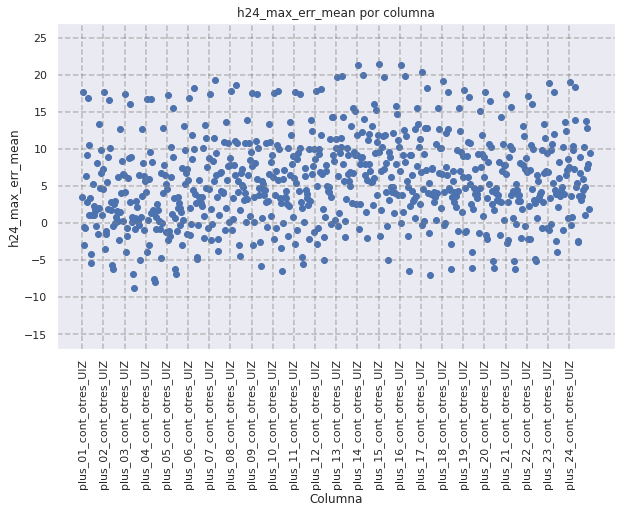

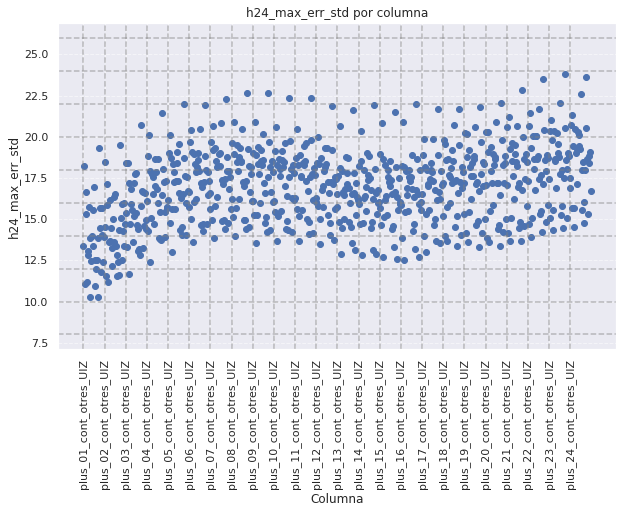

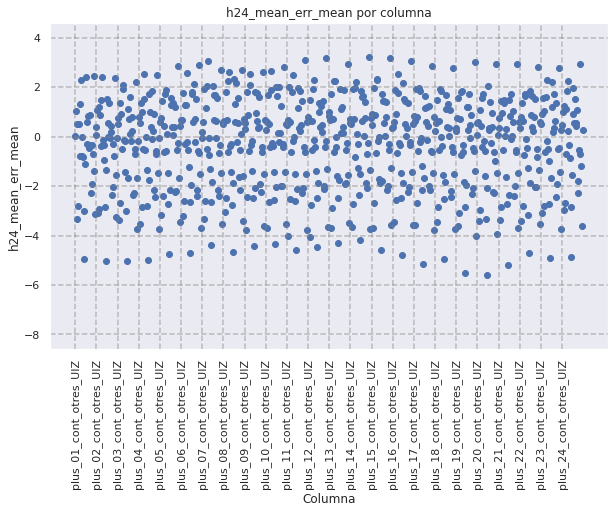

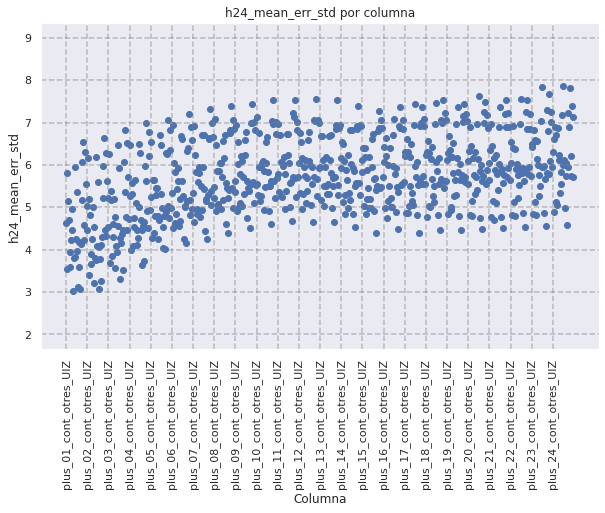

In [45]:
scatter_plot_by_column(results_df, 'h24_max_err_mean',
                output_results_folder_img)
scatter_plot_by_column(results_df, 'h24_max_err_std',
                output_results_folder_img)
scatter_plot_by_column(results_df, 'h24_mean_err_mean',
                output_results_folder_img)
scatter_plot_by_column(results_df, 'h24_mean_err_std',
                output_results_folder_img)

Promedio general de h24_max_err_mean sobre todas las estaciones: 5.6233


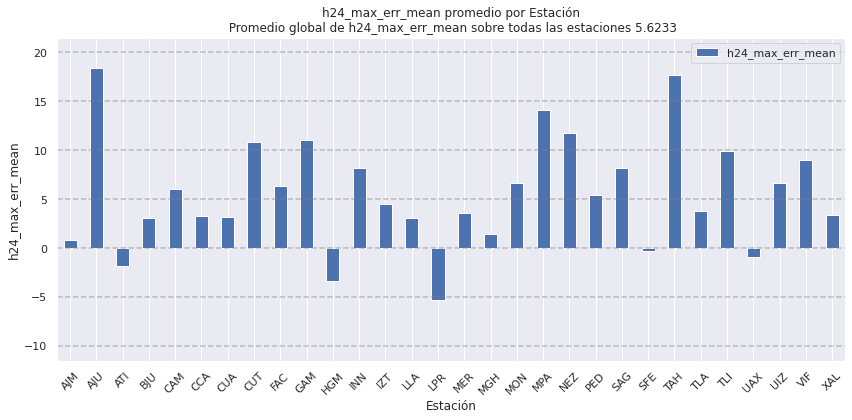

Promedio general de h24_max_err_std sobre todas las estaciones: 16.9372


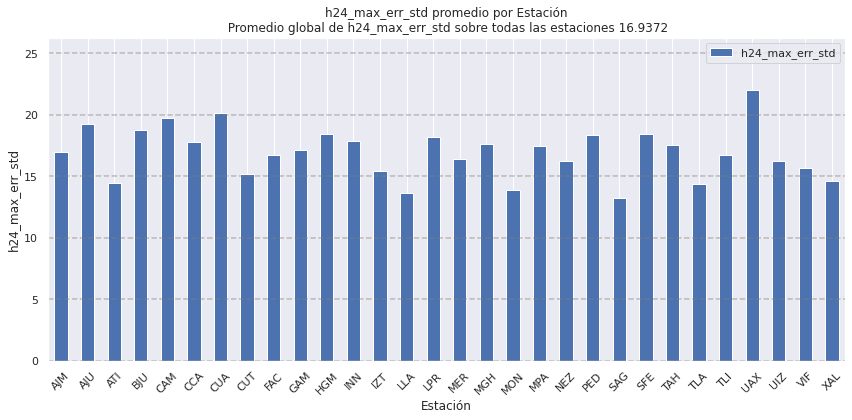

Promedio general de h24_mean_err_mean sobre todas las estaciones: -0.3575


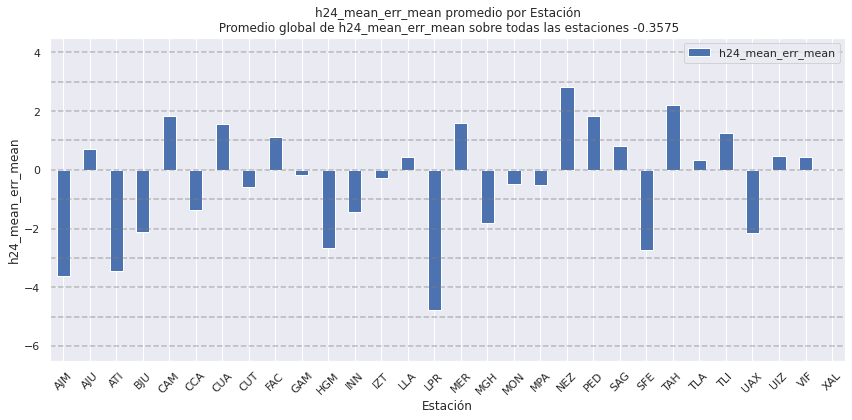

Promedio general de h24_mean_err_std sobre todas las estaciones: 5.7243


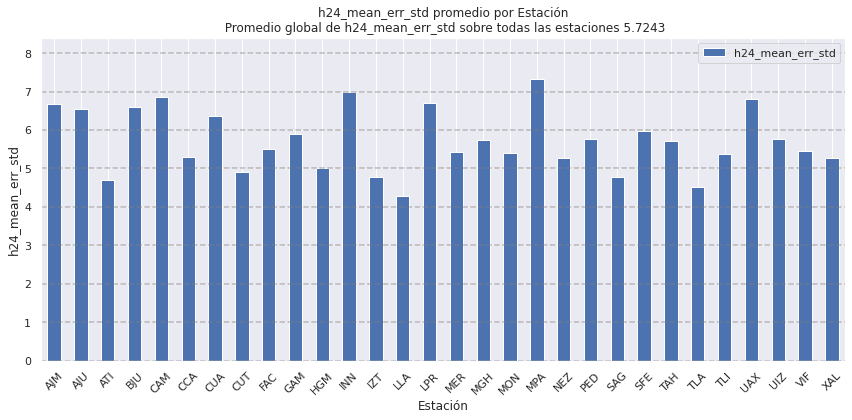

In [46]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Tu código aquí callando warnings
    average_metric(results_df, 'h24_max_err_mean', output_results_folder_img)
    average_metric(results_df, 'h24_max_err_std', output_results_folder_img)
    average_metric(results_df, 'h24_mean_err_mean', output_results_folder_img)
    average_metric(results_df, 'h24_mean_err_std', output_results_folder_img)

Promedio general de h24_max_err_mean sobre todas las horas: 5.6233


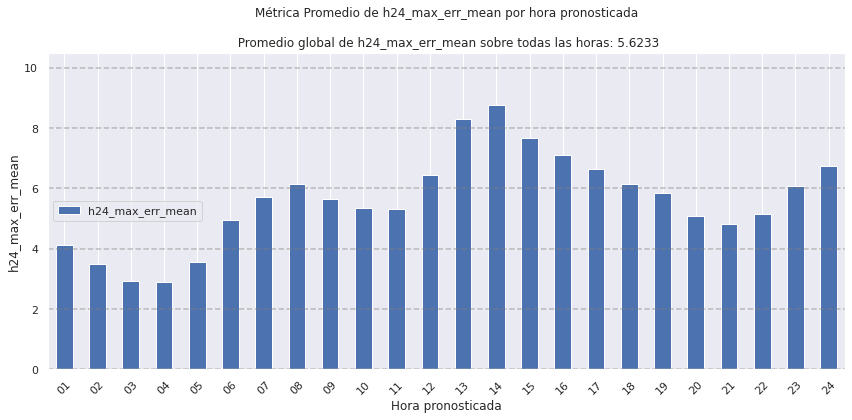

Promedio general de h24_max_err_std sobre todas las horas: 16.9372


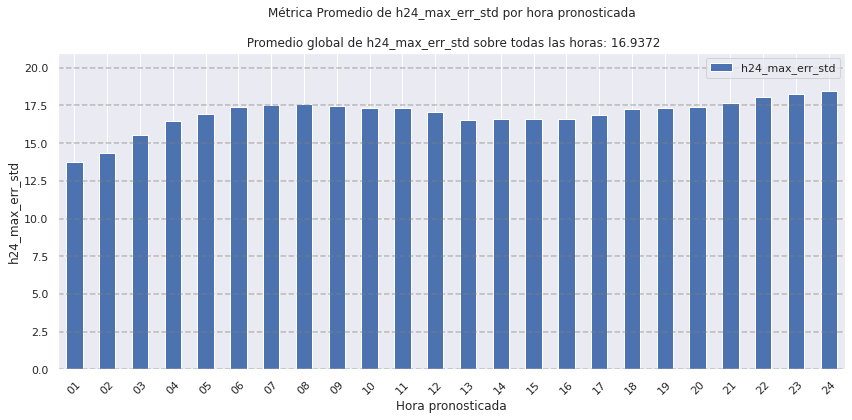

Promedio general de h24_mean_err_mean sobre todas las horas: -0.3575


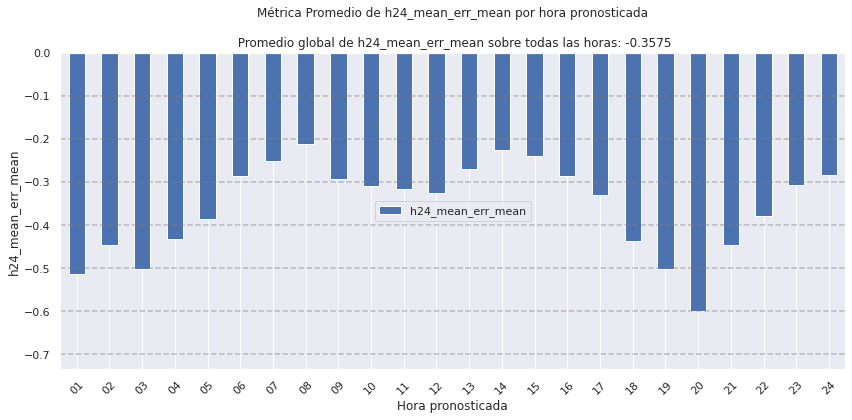

Promedio general de h24_mean_err_std sobre todas las horas: 5.7243


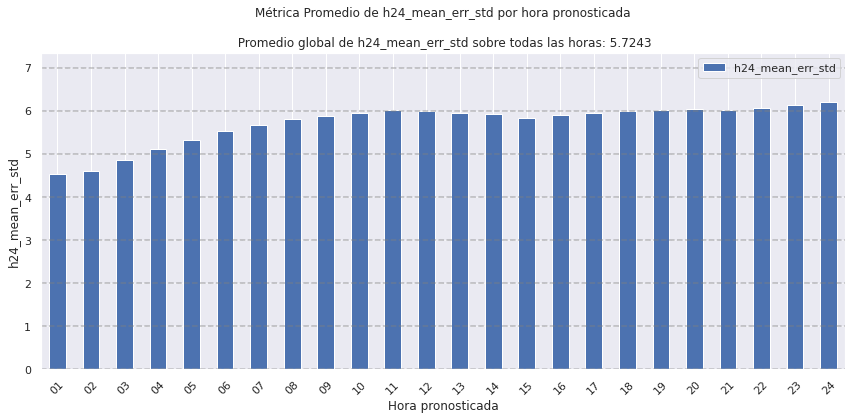

In [47]:

#with warnings.catch_warnings():
#    warnings.simplefilter("ignore")
    # Tu código aquí callando warnings
average_metric_by_hour(results_df, 'h24_max_err_mean', output_results_folder_img)
average_metric_by_hour(results_df, 'h24_max_err_std', output_results_folder_img)
average_metric_by_hour(results_df, 'h24_mean_err_mean', output_results_folder_img)
average_metric_by_hour(results_df, 'h24_mean_err_std', output_results_folder_img)

In [48]:
for index, row in results_df.iterrows():
    print(row)

Columna                  plus_01_cont_otres_UIZ
Índice de correlación                  0.935202
MAE                                    7.211486
MAPE                       383603879538196.5625
MSE                                   89.275782
RMSE                                   9.448586
R2                                     0.868284
h24_max_err_mean                       3.593998
h24_max_err_std                       13.371078
h24_mean_err_mean                      0.015693
h24_mean_err_std                       4.624591
Name: 0, dtype: object
Columna                  plus_01_cont_otres_AJU
Índice de correlación                  0.902606
MAE                                   11.371191
MAPE                      256470246813604.53125
MSE                                  211.629088
RMSE                                  14.547477
R2                                     0.690458
h24_max_err_mean                      17.653793
h24_max_err_std                       18.218609
h24_mean_err_mean

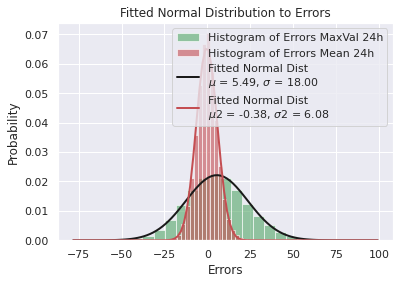

In [49]:
# Case for overall h24_max_err of the model

import numpy as np

from scipy.stats import norm


overall_errors = []

# Loop over the dictionary keys and values

for columna, values in errors_dict.items():

    max_y_true = values['max_y_true']

    max_y_pred = values['max_y_pred']

    errors = max_y_true - max_y_pred

    # Filtering out zeros

    for error in errors:

        if error != 0:

            overall_errors.append(error)


# Convert to numpy array for easier statistical analysis

overall_errors = np.array(overall_errors)


# Fit a normal distribution to the errors data

mu, std = norm.fit(overall_errors)


# Create a histogram of the errors

plt.hist(overall_errors, bins=25, density=True, alpha=0.6, color='g', label="Histogram of Errors MaxVal 24h")


# Create a PDF of the normal distribution

xmin, xmax = plt.xlim()

x = np.linspace(xmin, xmax, 100)

p = norm.pdf(x, mu, std)

overall_errors2 = []

# Loop over the dictionary keys and values

for columna, values in errors_dict.items():

    max_y_true = values['mean_y_true']

    max_y_pred = values['mean_y_pred']

    errors = max_y_true - max_y_pred

    # Filtering out zeros

    for error in errors:

        if error != 0:

            overall_errors2.append(error)


# Convert to numpy array for easier statistical analysis

overall_errors2 = np.array(overall_errors2)

plt.hist(overall_errors2, bins=25, density=True, alpha=0.6, color='r', label="Histogram of Errors Mean 24h")

mu2, std2 = norm.fit(overall_errors2)
p2 = norm.pdf(x, mu2, std2)


plt.plot(x, p, 'k', linewidth=2, label=f"Fitted Normal Dist\n$\mu$ = {mu:.2f}, $\sigma$ = {std:.2f}")
plt.plot(x, p2, 'r', linewidth=2, label=f"Fitted Normal Dist\n$\mu2$ = {mu2:.2f}, $\sigma2$ = {std2:.2f}")


plt.xlabel("Errors")

plt.ylabel("Probability")

plt.title("Fitted Normal Distribution to Errors")

plt.legend()

plt.show()

#mean_np, std_np, mu, std